In [1]:
import os

from bs4 import BeautifulSoup
import requests
import re
import json

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.reset_orig()
# from collections import defaultdict


In [2]:
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['font.size'] = 12

## Scraping info from one listing

In [3]:
ex_page = "https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Eimsbuettel.4874296.html"

In [194]:
ex_page = "https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Eimsbuettel.6065185.html"

In [4]:
r = requests.get(ex_page)

In [5]:
soup = BeautifulSoup(r.text, "lxml")

In [3]:
with open("Tests/4874296_de.html") as f:
    soup = BeautifulSoup(f.read(), "lxml")

In [4]:
panel_bodies = soup.find_all("div", "panel-body")

In [200]:
with open("debug.html", "w") as f:
    f.write(str(soup))

In [5]:
def get_coords(soup):
    gmap_text = soup.find("div", onclick=re.compile(r"loadGMap.*"))['onclick']
    return [float(x) for x in re.findall(r"[0-9\.]+", gmap_text)[0:2]]

In [6]:
get_coords(soup)

[53.570961, 9.956365]

In [7]:
panel_info = panel_bodies[0]

In [8]:
price_translation = {
    'miete': "base_rent",
    "nebenkosten": "utilities",
    "sonstige_kosten": "miscellaneous_costs",
    "kaution": "deposit",
    "abstandszahlung": "existing_equipment_fees"
}

def get_price_dict(panel):
    raw_prices = panel.find('div', 'col-xs-12 col-sm-5')
    price_list = [x.text.lower().strip().strip(":€").replace(" ", "_").replace("n.a.", "0")
                  for x in raw_prices.find_all('td') 
                  if not x.text.upper().strip().startswith('SCHUFA')]
    price_dict = {}
    for name, price in zip(price_list[:-1:2], price_list[1::2]):
        price_dict[name] = int(price)
    for k, v in price_translation.items():
        if k in price_dict.keys():
            price_dict[v] = price_dict[k]
            price_dict.pop(k, None)
    return price_dict

In [9]:
get_price_dict(panel_info)

{'base_rent': 410, 'deposit': 1300, 'miscellaneous_costs': 25, 'utilities': 80}

In [10]:
def get_address_dict(panel):
    raw_address = panel.find('div', 'col-xs-12 col-sm-4').find('a').text
    address_parts = [x.strip() for x in  raw_address.split('\n') if x.strip() != '']
    house_line =  re.sub(r'  +', ' ', address_parts[0])
    house_parts = house_line.split()
    house_number = -1
    for hp in house_parts:
        if hp.isdigit():
            house_number = hp
            house_line = house_line.replace(house_number, "").strip()
            break
    street = house_line

    postcode_line = re.sub(r'  +', ' ', address_parts[1])
    postcode_line = re.sub(r'Germany', '', postcode_line, flags=re.I | re.UNICODE)
    postcode_line = re.sub(r'Hamburg', '', postcode_line, flags=re.I | re.UNICODE)
    postcode_line = re.sub(r'[\n ]+', ' ', postcode_line)
    postcode_pattern = re.compile(r'(?P<postcode>2[\d]+) (?P<region>.*)', flags=re.I | re.UNICODE)
    postcode_match = postcode_pattern.search(postcode_line)
    postcode = postcode_match['postcode']
    region = postcode_match['region']    
    return {'street': street, 'house_number': int(house_number), 'region': postcode_match['region'], 'postcode': int(postcode_match['postcode'])}

In [11]:
get_address_dict(panel_info)

{'house_number': -1,
 'postcode': 20259,
 'region': 'Eimsbüttel',
 'street': 'Osterstraße'}

In [12]:
def get_availability_dict(panel):
    availability = panel.find('div', 'col-xs-12 col-sm-3')
    availability_values = [x.text.strip() for x in availability.find_all('b')]
    return dict(zip(['start_date', 'ad_placed'], availability_values))

In [13]:
get_availability_dict(panel_info)

{'ad_placed': 'Online: 13 Stunden', 'start_date': '27.04.2017'}

In [14]:
panel_details = panel_bodies[1]

In [15]:
def get_details_dict(panel):
    raw_details, searching_details = panel.find_all('div', 'col-sm-6')
    space_pattern = re.compile(r'[\n ]+')
    details_parts = [space_pattern.sub(' ', x.text.strip()) for x in raw_details.find_all('li')]
    details_text = " ".join(details_parts)
    
    room_area = 0
    area_pattern = re.compile(r'[0-9]+')
    area_match = area_pattern.match(details_parts[0].split()[0])
    if area_match:
        room_area = int(area_match[0])

    total_area = 0
    size_pattern = re.compile(r'Wohnungsgröße: ([0-9]+)', flags=re.I)
    size_match = size_pattern.search(details_parts[1])
    if size_match:
        total_area = int(size_match[1])

    total_num_persons = 0
    np_pattern = re.compile(r'([0-9]+)er WG')
    num_persons_match = np_pattern.search(details_text)
    if num_persons_match:
        total_num_persons = int(num_persons_match[1])

    num_females, num_males = 0, 0
    male_female_pattern = re.compile(r'([0-9]+) Frau(?:en)? und ([0-9]+) M[aä]nn',  flags=re.I|re.U)
    genders_match = male_female_pattern.search(details_text)
    if genders_match:
        num_females, num_males = int(genders_match[1]), int(genders_match[2])

    workers_pattern = re.compile(r'Berufstätigen-WG', flags=re.I | re.U)
    students_pattern = re.compile(r'Studenten-WG', flags=re.I)
    workers_ok, students_ok = False, False
    workers_ok = not workers_pattern.search(details_text)
    students_ok = not students_pattern.search(details_text)
    
    languages = []
    for lang_img in raw_details.find_all('img'):
        languages.append(lang_img['title'].lower())
    
    current_min_age, current_max_age = -1, -1
    current_age_pattern = re.compile(r"Bewohneralter: (\d+) bis (\d+) Jahre", flags=re.I | re.U)
    current_age_match = current_age_pattern.search(details_text)
    if current_age_match:
        current_min_age, current_max_age = int(current_age_match[1]), int(current_age_match[2])
    
    desired_min_age, desired_max_age = -1, -1
    desired_age_pattern = re.compile(r"zwischen (\d+) und (\d+) Jahren", flags=re.I | re.U)
    desired_age_match = desired_age_pattern.search("".join(searching_details.text))
    if desired_age_match:
        desired_min_age, desired_max_age = int(desired_age_match[1]), int(desired_age_match[2])
    
    return {'room_area': room_area, 'total_area': total_area, 
            'num_males_current': num_males, 'num_females_current': num_females, 
            'total_occupancy': total_num_persons,
            'workers_ok': workers_ok, 'students_ok': students_ok,
            "languages": languages,
            "current_min_age": current_min_age, "current_max_age": current_max_age,
            "desired_min_age": desired_min_age, "desired_max_age": desired_max_age}

In [16]:
get_details_dict(panel_details)

{'current_max_age': 26,
 'current_min_age': 24,
 'desired_max_age': 30,
 'desired_min_age': 18,
 'languages': ['deutsch', 'englisch'],
 'num_females_current': 0,
 'num_males_current': 2,
 'room_area': 12,
 'students_ok': False,
 'total_area': 0,
 'total_occupancy': 3,
 'workers_ok': False}

In [17]:
panel_features = panel_bodies[2]

In [18]:
f = re.sub(r' {2,}', '', panel_features.text)
[x.replace('\n', ' ') for x in re.split(r'\n{2,}', f) if x]

['Angaben zum Objekt',
 'Altbau',
 'Dusche',
 'Flatrate',
 'DSL, Flatrate, WLAN26-50 Mbit/s',
 'Dielen',
 'schlechte Parkmöglichkeiten',
 '1 Minute zu Fuß entfernt',
 'Waschmaschine, Spülmaschine, Balkon, Keller']

In [19]:
def get_features_dict(panel):
    features_dict = {}
    f = re.sub(r' {2,}', '', panel.text)
    flist = [x.replace('\n', ' ').lower() for x in re.split(r'\n{2,}', f) if x]

    # Now pick out certain features
    def _find_keyword(keyword):
        return any(keyword.lower() in x for x in flist)
    
    if _find_keyword('altbau'):
        features_dict['building'] = "old"
    if _find_keyword('neubau'): 
        features_dict['building'] = "new"
    
    features_dict['balcony'] = _find_keyword('balkon')
    features_dict['washing_machine'] = _find_keyword('waschmaschine')
    features_dict['dishwasher'] = _find_keyword('spülmaschine')
    features_dict['cellar'] = _find_keyword('keller')
    features_dict['garden'] = _find_keyword('garten')
    
    features_dict['transport_distance'] = -1
    for x in flist:
        match = re.search(r'([0-9]+) minute(n)? zu fuß', x, flags=re.I | re.U)
        if match:
            features_dict['transport_distance'] = int(match[1])
            break
    
    return features_dict

get_features_dict(panel_features)

{'balcony': True,
 'building': 'old',
 'cellar': True,
 'dishwasher': True,
 'garden': False,
 'transport_distance': 1,
 'washing_machine': True}

In [29]:
def check_ad_useful(soup):
    return not("der Inserent hat bereits genug Anfragen erhalten" in soup.text or "Anzeige nicht vorhanden" in soup.text)

In [30]:
def extract_ad_info_from_soup(ad_soup):
    panels = ad_soup.find_all("div", "panel-body")
    try:
        info_panel = panels[0]

        ad_dict = dict()
        ad_dict['latitude'], ad_dict['longitude'] = get_coords(ad_soup)
        
#         ad_dict = {'title': ad_soup.title.text}
        ad_dict.update(get_price_dict(info_panel))
        ad_dict.update(get_address_dict(info_panel))

        details_panel = panels[1]
        ad_dict.update(get_details_dict(details_panel))
        
        features_panel = panels[2]
        ad_dict.update(get_features_dict(features_panel))
    except IndexError:
        print("Cannot parse page")
        with open("debug.html", "w") as f:
            f.write(ad_soup.get_text())
        return None
    
    return ad_dict

In [22]:
extract_ad_info_from_soup(soup)

{'balcony': True,
 'base_rent': 410,
 'building': 'old',
 'cellar': True,
 'current_max_age': 26,
 'current_min_age': 24,
 'deposit': 1300,
 'desired_max_age': 30,
 'desired_min_age': 18,
 'dishwasher': True,
 'garden': False,
 'house_number': -1,
 'languages': ['deutsch', 'englisch'],
 'latitude': 53.570961,
 'longitude': 9.956365,
 'miscellaneous_costs': 25,
 'num_females_current': 0,
 'num_males_current': 2,
 'postcode': 20259,
 'region': 'Eimsbüttel',
 'room_area': 12,
 'street': 'Osterstraße',
 'students_ok': False,
 'total_area': 0,
 'total_occupancy': 3,
 'transport_distance': 1,
 'utilities': 80,
 'washing_machine': True,
 'workers_ok': False}

In [23]:
def generate_cache_filename(url):
    return os.path.join("_cache", os.path.basename(url))    

In [24]:
def extract_ad_info(url, read_cache=True, save_cache=True):
    cache_filename = generate_cache_filename(url)
    cache_dir = os.path.dirname(cache_filename)
    
    page_contents = None
    
    if read_cache and os.path.isfile(cache_filename):
        print("Reading from cache", cache_filename)
        with open(cache_filename) as f:
            page_contents = f.read()
    else:    
        r = requests.get(url)
        if r.status_code != 200 or not r.ok:
            return None
        page_contents = r.text
        
    if save_cache and not os.path.isfile(cache_filename):
        print("Cacheing to", cache_filename)
        if not os.path.isdir(cache_dir):
            os.makedirs(cache_dir)
        with open(cache_filename, "w") as fout:
            fout.write(r.text)
            
    soup = BeautifulSoup(page_contents, 'lxml')
    if not check_ad_useful(soup):
        return None
    else:
        ad_dict = extract_ad_info_from_soup(soup)
        ad_dict['url'] = url
        return ad_dict

In [25]:
# failure
extract_ad_info('https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-St-Pauli.5796749.html')

Reading from cache _cache/wg-zimmer-in-Hamburg-St-Pauli.5796749.html


TypeError: 'NoneType' object is not subscriptable

In [26]:
extract_ad_info('http://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Eimsbuettel.5618920.html')

Reading from cache _cache/wg-zimmer-in-Hamburg-Eimsbuettel.5618920.html


{'balcony': False,
 'base_rent': 450,
 'building': 'old',
 'cellar': True,
 'current_max_age': 28,
 'current_min_age': 26,
 'deposit': 500,
 'desired_max_age': 30,
 'desired_min_age': 23,
 'dishwasher': True,
 'garden': False,
 'house_number': 21,
 'languages': ['deutsch', 'englisch', 'spanisch', 'französisch'],
 'latitude': 53.57168,
 'longitude': 9.97378,
 'miscellaneous_costs': 0,
 'num_females_current': 0,
 'num_males_current': 2,
 'postcode': 20144,
 'region': 'Eimsbüttel',
 'room_area': 16,
 'street': 'Kielortallee',
 'students_ok': True,
 'total_area': 78,
 'total_occupancy': 3,
 'transport_distance': 5,
 'url': 'http://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Eimsbuettel.5618920.html',
 'utilities': 50,
 'washing_machine': True,
 'workers_ok': False}

In [31]:
extract_ad_info('http://www.wg-gesucht.de/6091141.html')

Reading from cache _cache/6091141.html


In [32]:
extract_ad_info('https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Alsterdorf.5260672.html')

Reading from cache _cache/wg-zimmer-in-Hamburg-Alsterdorf.5260672.html


{'balcony': True,
 'base_rent': 370,
 'cellar': False,
 'current_max_age': 24,
 'current_min_age': 20,
 'deposit': 600,
 'desired_max_age': 27,
 'desired_min_age': 16,
 'dishwasher': False,
 'garden': False,
 'house_number': -1,
 'languages': ['deutsch', 'englisch'],
 'latitude': 53.609087,
 'longitude': 10.012045,
 'miscellaneous_costs': 0,
 'num_females_current': 1,
 'num_males_current': 1,
 'postcode': 22337,
 'region': 'Alsterdorf',
 'room_area': 12,
 'street': 'Alsterdorfstrasse',
 'students_ok': False,
 'total_area': 0,
 'total_occupancy': 3,
 'transport_distance': 3,
 'url': 'https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Alsterdorf.5260672.html',
 'utilities': 30,
 'washing_machine': False,
 'workers_ok': True}

In [755]:
get_listing_dict(listings[0])

{'date_advertised': '01.05.17',
 'distance': 0.6,
 'room_area': 30,
 'start_date': '01.06.17',
 'total_rent': 650,
 'url': 'https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Ottensen.6007384.html'}

In [33]:
import time
import random

In [34]:
def scrape_urls(url_list):
    print('Getting info on %d ads...' % len(url_list))
    dict_list = []
    for url in url_list:
        print(url)
        time.sleep(random.random()*5 + 1)
        info = extract_ad_info(url)
        if info:
            dict_list.append(info)
    return dict_list

In [412]:
urls = [
    'http://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Eimsbuettel.5618920.html',
    'https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Eimsbuettel.4874296.html',
    'https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Bahrenfeld.5313515.html',
    'https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Eppendorf.6066386.html',
    'https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Eimsbuettel.6065185.html',
    'https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Ottensen.5986295.html',
    'https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Eimsbuettel.6082464.html',
    'https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Altona-Nord.5672745.html',
    'https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Stellingen.6079042.html',
    'https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Eimsbuettel.6074471.html',
    'https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Harvestehude.5963393.html',
    'https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Altona-Nord.6064793.html',
    'https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Ottensen.4979594.html',
    'https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Ottensen.5248077.html',
    'https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Eimsbuettel.6059676.html',
    'https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Altona-Altstadt.6048834.html'
]

In [413]:
dicts = scrape_urls(urls)

Getting info on 16 ads...
http://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Eimsbuettel.5618920.html
Reading from cache _cache/wg-zimmer-in-Hamburg-Eimsbuettel.5618920.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Eimsbuettel.4874296.html
Cacheing to _cache/wg-zimmer-in-Hamburg-Eimsbuettel.4874296.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Bahrenfeld.5313515.html
Cacheing to _cache/wg-zimmer-in-Hamburg-Bahrenfeld.5313515.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Eppendorf.6066386.html
Cacheing to _cache/wg-zimmer-in-Hamburg-Eppendorf.6066386.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Eimsbuettel.6065185.html
Cacheing to _cache/wg-zimmer-in-Hamburg-Eimsbuettel.6065185.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Ottensen.5986295.html
Cacheing to _cache/wg-zimmer-in-Hamburg-Ottensen.5986295.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Eimsbuettel.6082464.html
Cacheing to _cache/wg-zimmer-in-Hamburg-Eimsbuettel.6082464.html
https://www.wg-gesuch

## Scraping to get lots of listings

Now wwe go through N pages that list ads for a given filter, and get the URLs, and some basic info:

In [35]:
list_page = "https://www.wg-gesucht.de/wg-zimmer-in-Hamburg.55.0.0.0.html?user_filter_id=397074&offer_filter=1&city_id=55&category=0&rent_type=2&sMin=12&rMax=700&dFr=1425168000&dTo=1497391200&radLat=53.55602559999999&radLng=9.922616500000004&radAdd=Ottensen%2C+Hamburg%2C+Germany&radDis=7000&wgSea=2&wgAge=26&wgMxT=3&img_only=1"

In [786]:
# test data
rall = requests.get(list_page)
soup_all = BeautifulSoup(rall.text, 'lxml')
listings = soup_all.find_all('tr', class_=re.compile(r'listenansicht[01]'))
print(len(listings))

20


In [36]:
def get_listing_dict(listing):
    listing_info = [s.text.strip() for s in listing.find_all('span') if s.text.strip()]
    listing_cols = ['date_advertised', 'total_rent', 'room_area', 'distance', 'start_date']
    listing_dict = dict(zip(listing_cols, listing_info))
    listing_dict['url'] = "https://www.wg-gesucht.de/" + listing.find('a', class_=re.compile('listenansicht[01]'), href=re.compile('wg-.*'))['href']
    listing_dict['room_area'] = int(re.match(r'[0-9]+', listing_dict['room_area'])[0])
    listing_dict['total_rent'] = int(listing_dict['total_rent'].strip('€'))
    listing_dict['distance'] = float(listing_dict['distance'].strip(" km").replace(",", "."))
    return listing_dict

In [833]:
get_listing_dict(listings[0])

{'date_advertised': '10.03.17',
 'distance': 4.0,
 'room_area': 12,
 'start_date': '01.03.17',
 'total_rent': 400,
 'url': 'https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Bahrenfeld.5328405.html'}

In [453]:
get_listing_dict(listings[1])

{'date_advertised': '01.05.17',
 'distance': 1.1,
 'room_area': 17,
 'start_date': '01.06.17',
 'total_rent': 554,
 'url': 'https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Bahrenfeld.6095695.html'}

In [38]:
def get_listings_from_list_page(url):
    rall = requests.get(url)
    soup_all = BeautifulSoup(rall.text, 'lxml')
    listings = soup_all.find_all('tr', class_=re.compile(r'listenansicht[01]'))
    listings_dicts = [get_listing_dict(listing) for listing in listings]
    print("Got %d listings" % len(listings_dicts))
    return listings_dicts
    

In [39]:
list_page_template = list_page.replace("0.html", "{N}.html")
listings_dicts = []
for i in range(10):
    print("Getting page %d of listings from %s" %(i+1, list_page))
    list_page = list_page_template.replace("{N}", str(i))
    time.sleep(random.random()*5 + 1)    
    listings_dicts.extend(get_listings_from_list_page(list_page))
print("Collected a total of %d listings" % len(listings_dicts))

Getting page 1 of listings from https://www.wg-gesucht.de/wg-zimmer-in-Hamburg.55.0.0.0.html?user_filter_id=397074&offer_filter=1&city_id=55&category=0&rent_type=2&sMin=12&rMax=700&dFr=1425168000&dTo=1497391200&radLat=53.55602559999999&radLng=9.922616500000004&radAdd=Ottensen%2C+Hamburg%2C+Germany&radDis=7000&wgSea=2&wgAge=26&wgMxT=3&img_only=1
Got 20 listings
Getting page 2 of listings from https://www.wg-gesucht.de/wg-zimmer-in-Hamburg.55.0.0.0.html?user_filter_id=397074&offer_filter=1&city_id=55&category=0&rent_type=2&sMin=12&rMax=700&dFr=1425168000&dTo=1497391200&radLat=53.55602559999999&radLng=9.922616500000004&radAdd=Ottensen%2C+Hamburg%2C+Germany&radDis=7000&wgSea=2&wgAge=26&wgMxT=3&img_only=1
Got 20 listings
Getting page 3 of listings from https://www.wg-gesucht.de/wg-zimmer-in-Hamburg.55.0.0.1.html?user_filter_id=397074&offer_filter=1&city_id=55&category=0&rent_type=2&sMin=12&rMax=700&dFr=1425168000&dTo=1497391200&radLat=53.55602559999999&radLng=9.922616500000004&radAdd=Ottens

Add detailed ad info here to each listing:

In [40]:
def update_listing_info(listings):
    for i, d in enumerate(listings):
        if not os.path.isfile(generate_cache_filename(d['url'])):
            if i % 10 == 0 and i > 0:
                print('Long sleep, done %d / %d' % (i, len(listings)))
                time.sleep(60)
            time.sleep(random.random()*2 + 1)
        print(d['url'])
        info = extract_ad_info(d['url'])
        if info:
            d.update(info)

In [41]:
update_listing_info(listings_dicts)

https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Uhlenhorst.2679233.html
Reading from cache _cache/wg-zimmer-in-Hamburg-Uhlenhorst.2679233.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Winterhude.4816146.html
Reading from cache _cache/wg-zimmer-in-Hamburg-Winterhude.4816146.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Wilhelmsburg.6035988.html
Reading from cache _cache/wg-zimmer-in-Hamburg-Wilhelmsburg.6035988.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Uhlenhorst.5984489.html
Reading from cache _cache/wg-zimmer-in-Hamburg-Uhlenhorst.5984489.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Eimsbuettel.6097661.html
Cacheing to _cache/wg-zimmer-in-Hamburg-Eimsbuettel.6097661.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Othmarschen.6097523.html
Cacheing to _cache/wg-zimmer-in-Hamburg-Othmarschen.6097523.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Veddel.4021331.html
Reading from cache _cache/wg-zimmer-in-Hamburg-Veddel.4021331.html
https://www.wg-gesuc

https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Barmbek-Sued.5470803.html
Reading from cache _cache/wg-zimmer-in-Hamburg-Barmbek-Sued.5470803.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-St-Georg.5058705.html
Reading from cache _cache/wg-zimmer-in-Hamburg-St-Georg.5058705.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Ottensen.5366923.html
Reading from cache _cache/wg-zimmer-in-Hamburg-Ottensen.5366923.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Ottensen.6060847.html
Reading from cache _cache/wg-zimmer-in-Hamburg-Ottensen.6060847.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Rotherbaum.6047911.html
Reading from cache _cache/wg-zimmer-in-Hamburg-Rotherbaum.6047911.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Eimsbuettel.5618920.html
Reading from cache _cache/wg-zimmer-in-Hamburg-Eimsbuettel.5618920.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Neustadt.6085909.html
Reading from cache _cache/wg-zimmer-in-Hamburg-Neustadt.6085909.html
https://www.wg-g

https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Eppendorf.5941496.html
Reading from cache _cache/wg-zimmer-in-Hamburg-Eppendorf.5941496.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Eimsbuettel.6059860.html
Reading from cache _cache/wg-zimmer-in-Hamburg-Eimsbuettel.6059860.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Eppendorf.6065999.html
Reading from cache _cache/wg-zimmer-in-Hamburg-Eppendorf.6065999.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Eimsbuettel.5136014.html
Reading from cache _cache/wg-zimmer-in-Hamburg-Eimsbuettel.5136014.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Neustadt.6062760.html
Reading from cache _cache/wg-zimmer-in-Hamburg-Neustadt.6062760.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Ottensen.5945712.html
Reading from cache _cache/wg-zimmer-in-Hamburg-Ottensen.5945712.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Altona-Altstadt.6048834.html
Reading from cache _cache/wg-zimmer-in-Hamburg-Altona-Altstadt.6048834.html
http

https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Uhlenhorst.6015470.html
Reading from cache _cache/wg-zimmer-in-Hamburg-Uhlenhorst.6015470.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-St-Pauli.5832723.html
Reading from cache _cache/wg-zimmer-in-Hamburg-St-Pauli.5832723.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Bahrenfeld.5989963.html
Reading from cache _cache/wg-zimmer-in-Hamburg-Bahrenfeld.5989963.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Ottensen.6017062.html
Reading from cache _cache/wg-zimmer-in-Hamburg-Ottensen.6017062.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Bahrenfeld.6016642.html
Reading from cache _cache/wg-zimmer-in-Hamburg-Bahrenfeld.6016642.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Ottensen.5695330.html
Reading from cache _cache/wg-zimmer-in-Hamburg-Ottensen.5695330.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Bahrenfeld.6014736.html
Reading from cache _cache/wg-zimmer-in-Hamburg-Bahrenfeld.6014736.html
https://www.wg-ges

In [44]:
def dump_dict_to_json(data, json_filename):
    with open(json_filename, 'w') as fp:
        json.dump(data, fp, indent=4)

In [45]:
dump_dict_to_json(listings_dicts, "listings.json")

# Dataframes

In [46]:
df = pd.DataFrame(listings_dicts)

In [414]:
df = pd.DataFrame(dicts)

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 35 columns):
balcony                    200 non-null bool
base_rent                  200 non-null int64
building                   148 non-null object
cellar                     200 non-null bool
current_max_age            200 non-null int64
current_min_age            200 non-null int64
date_advertised            200 non-null object
deposit                    179 non-null float64
desired_max_age            200 non-null int64
desired_min_age            200 non-null int64
dishwasher                 200 non-null bool
distance                   200 non-null float64
existing_equipment_fees    64 non-null float64
garden                     200 non-null bool
house_number               200 non-null int64
languages                  200 non-null object
latitude                   200 non-null float64
longitude                  200 non-null float64
miscellaneous_costs        200 non-null int64
num_females_c

In [52]:
# Ensure numeric, swap NaNs for 0s
for col in ['base_rent', 'deposit', 'existing_equipment_fees', 'miscellaneous_costs', 'utilities']:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(value=0)
df.drop(df.query('base_rent == 0').index, inplace=True)

In [51]:
# Convert date strings to proper dtype
for col in ['date_advertised', 'start_date']:
    df[col] = pd.to_datetime(df[col], dayfirst=True)

In [50]:
# turn language list into dummy variables
s = df['languages']
# need to do the .apply.stack as geT_dummies doens't behave properly
dummy_lang = pd.get_dummies(s.apply(pd.Series).stack(), prefix="speaks").sum(level=0)
df = pd.concat([df, dummy_lang], axis=1)  
# get NaNs for ads that have 0 languages
for c in dummy_lang.columns.values:
    df[c] = pd.to_numeric(df[c].fillna(value=0), downcast='integer')

In [53]:
df.head()

,balcony,base_rent,building,cellar,current_max_age,current_min_age,date_advertised,deposit,desired_max_age,desired_min_age,...,speaks_französisch,speaks_gebärdensprache,speaks_italienisch,speaks_japanisch,speaks_niederländisch,speaks_norwegisch,speaks_polnisch,speaks_russisch,speaks_schwedisch,speaks_spanisch
0,False,400,NaN,False,35,33,2017-05-03,800.0,99,25,...,0,0,0,0,0,0,0,0,0,0
1,False,220,old,True,34,25,2017-05-03,655.0,36,22,...,0,0,0,0,0,0,0,0,0,0
2,False,344,old,True,35,30,2017-05-03,1.0,45,23,...,0,0,0,0,0,0,0,0,0,0
3,True,480,old,False,43,7,2017-05-02,0.0,99,25,...,0,0,0,0,0,0,0,0,0,0
4,False,270,old,True,22,21,2017-05-02,775.0,29,20,...,0,0,0,0,0,0,0,0,0,0


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 199
Data columns (total 48 columns):
balcony                    200 non-null bool
base_rent                  200 non-null int64
building                   148 non-null object
cellar                     200 non-null bool
current_max_age            200 non-null int64
current_min_age            200 non-null int64
date_advertised            200 non-null datetime64[ns]
deposit                    200 non-null float64
desired_max_age            200 non-null int64
desired_min_age            200 non-null int64
dishwasher                 200 non-null bool
distance                   200 non-null float64
existing_equipment_fees    200 non-null float64
garden                     200 non-null bool
house_number               200 non-null int64
languages                  200 non-null object
latitude                   200 non-null float64
longitude                  200 non-null float64
miscellaneous_costs        200 non-null int64
num_

In [55]:
df.region.unique().tolist()

['Uhlenhorst',
 'Winterhude',
 'Wilhelmsburg',
 'Eimsbüttel',
 'Othmarschen',
 'Veddel',
 'St Pauli',
 'Neustadt',
 'St Georg',
 'Finkenwerder',
 'Bahrenfeld',
 'Altona-Nord',
 'Ottensen',
 'Sternschanze',
 'Altona-Altstadt',
 'Eppendorf',
 'Harvestehude',
 'Hoheluft-Ost',
 'Rotherbaum',
 'Hamm-Mitte',
 'Stellingen',
 'Iserbrook',
 'St. Georg',
 'Lurup',
 'Barmbek-Süd',
 'Münzviertel Hammerbrook / St. Georg',
 'Elmshorn',
 'Lokstedt',
 'Schanzenviertel',
 'Borgfelde',
 'Osdorf',
 'Altona/ ottensen',
 'Blankenese',
 '',
 'Altona',
 'Hoheluft-West',
 'Eidelstedt']

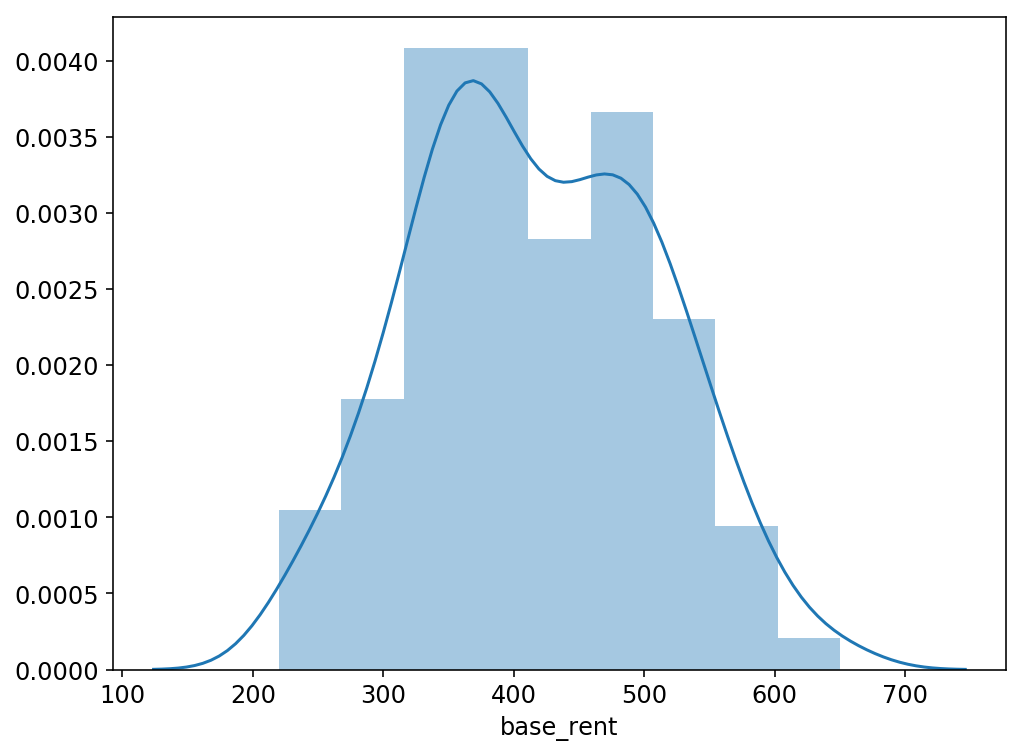

In [56]:
sns.distplot(df.base_rent);

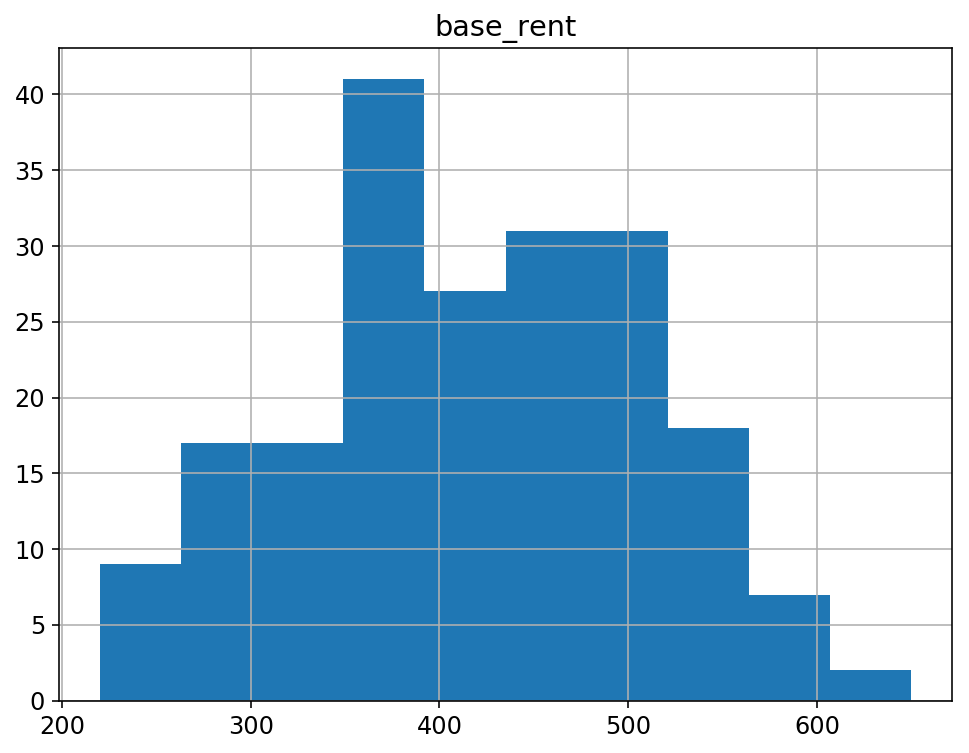

In [57]:
df.hist('base_rent');

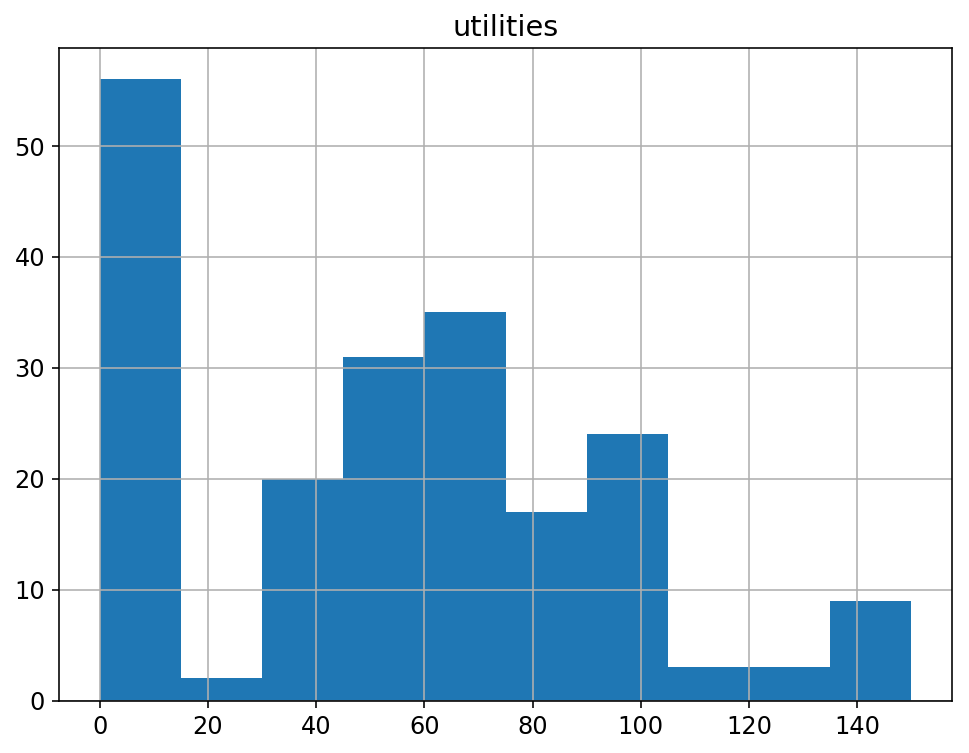

In [58]:
df.hist('utilities');

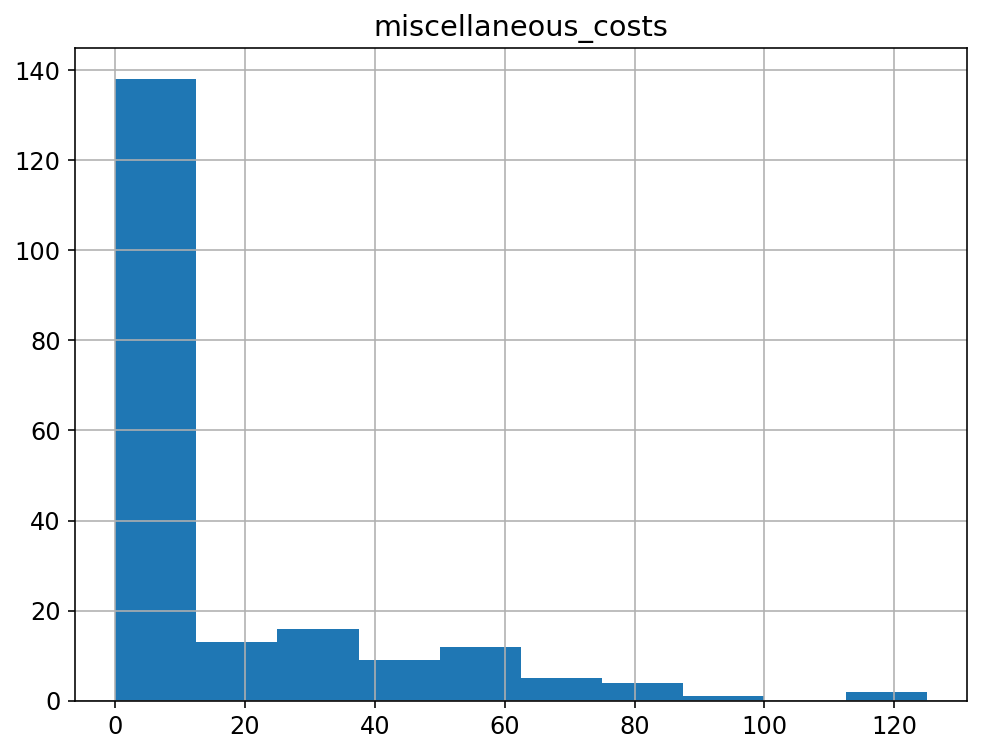

In [59]:
df.hist('miscellaneous_costs');

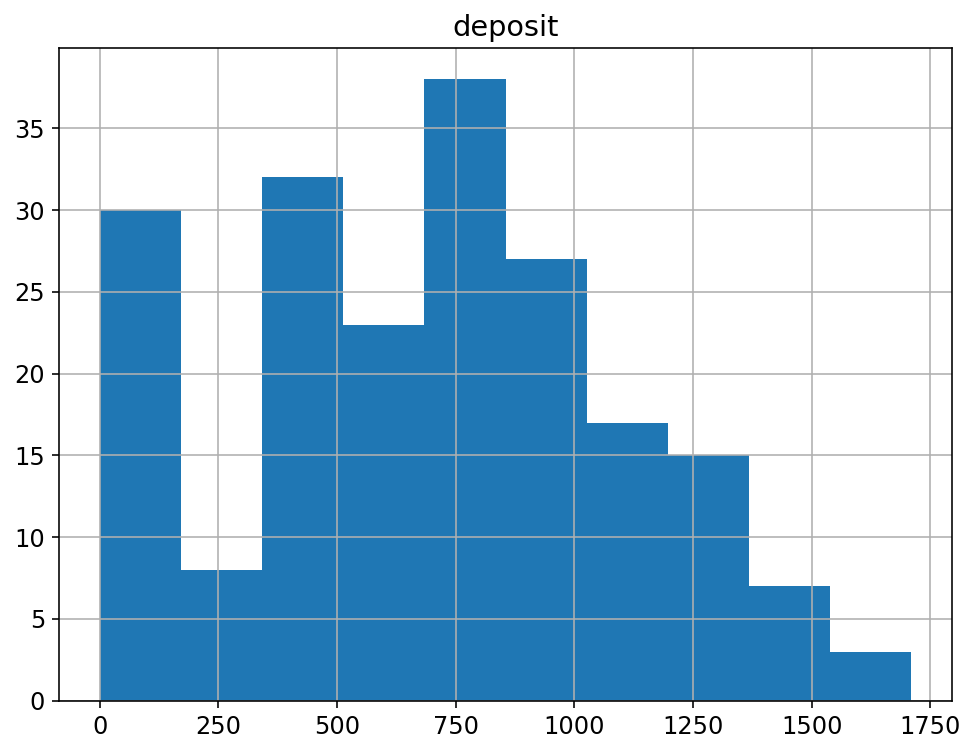

In [60]:
df.hist('deposit');

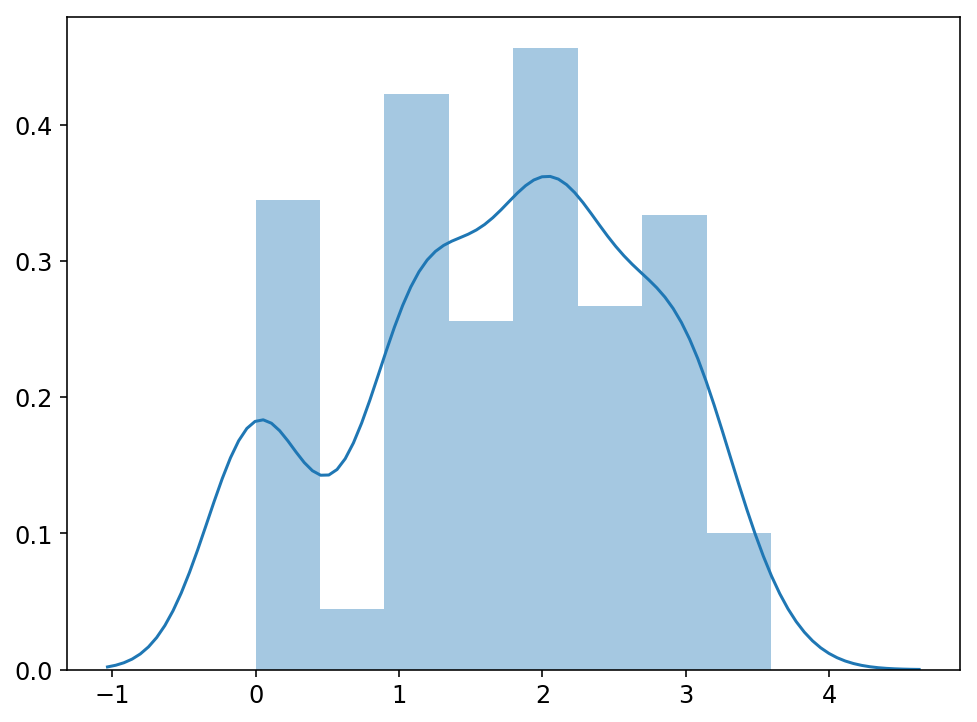

In [61]:
sns.distplot(df.deposit / df.base_rent);

In [62]:
def compare_distributions(groupby, column, **this_plot_opts):
    plot_opts = dict(histtype='stepfilled', alpha=0.2)
    plot_opts.update(this_plot_opts)
    grps = df.groupby(groupby)
    for key, grp in df.groupby(groupby):
        grp[column].plot.hist(sharex=True, sharey=True, ax=plt.gca(),
                              label=str(key), 
                              title="%s grouped by %s" % (column, groupby), 
                              **plot_opts)
    plt.legend();
    plt.minorticks_on()

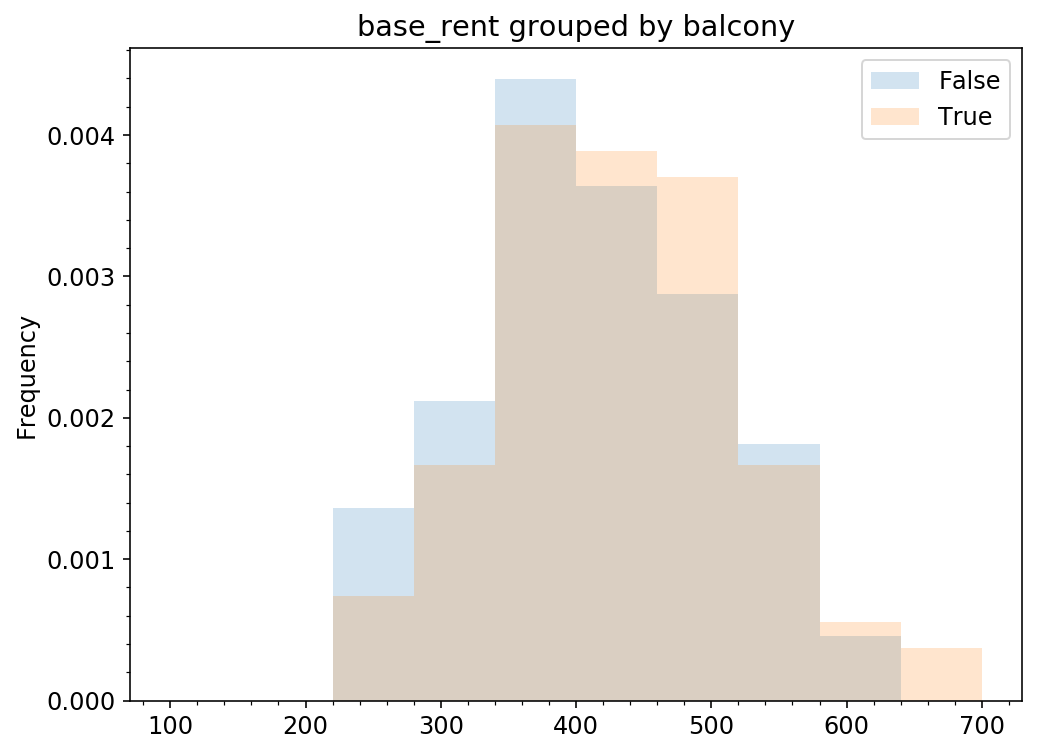

In [63]:
compare_distributions('balcony', 'base_rent', 
                      bins=10, range=[100, 700], alpha=0.2, normed=True)

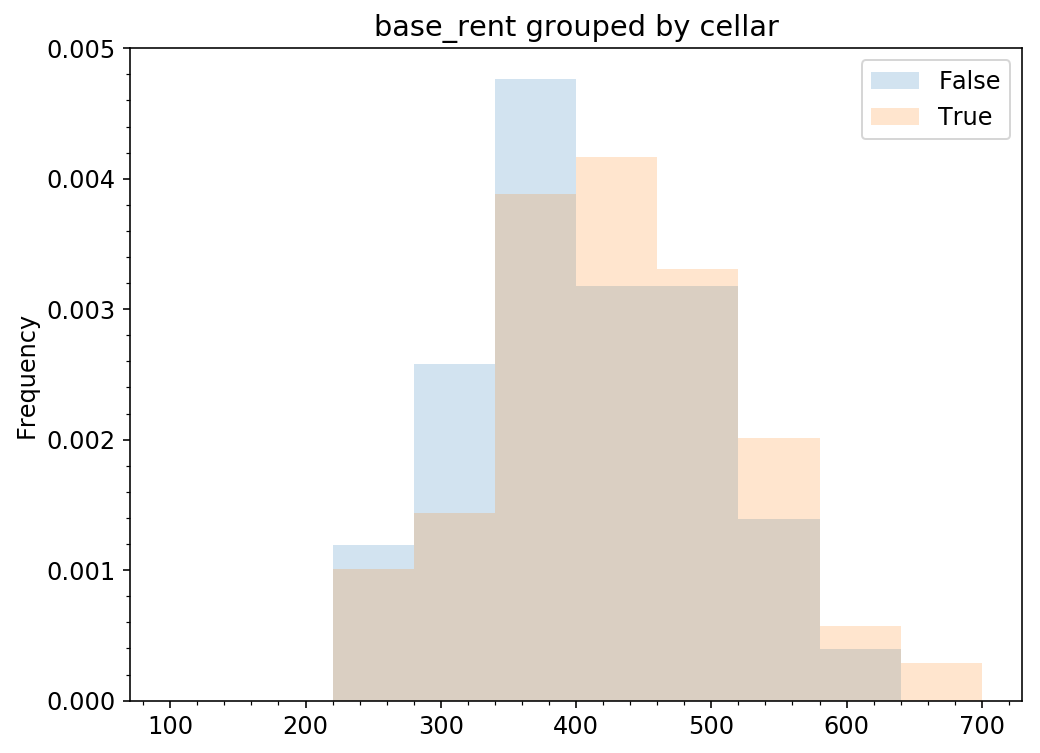

In [64]:
compare_distributions('cellar', 'base_rent', 
                      bins=10, range=[100, 700], histtype='stepfilled', alpha=0.2, normed=True)

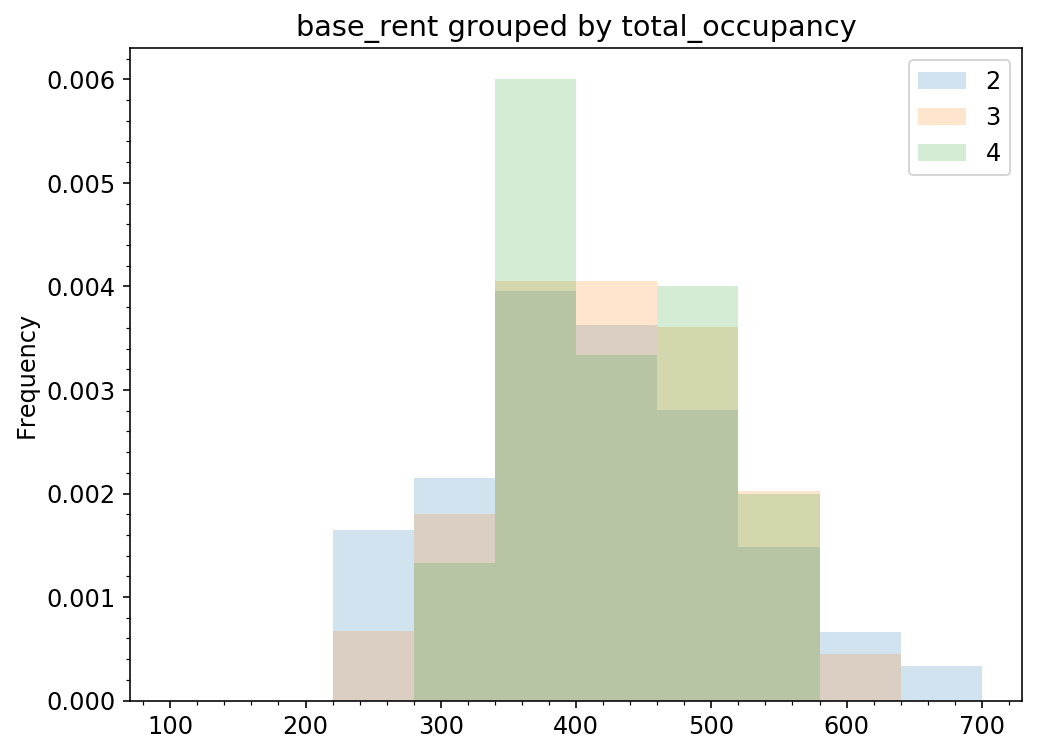

In [65]:
compare_distributions('total_occupancy', 'base_rent', 
                      bins=10, range=[100, 700], histtype='stepfilled', alpha=0.2, normed=True)

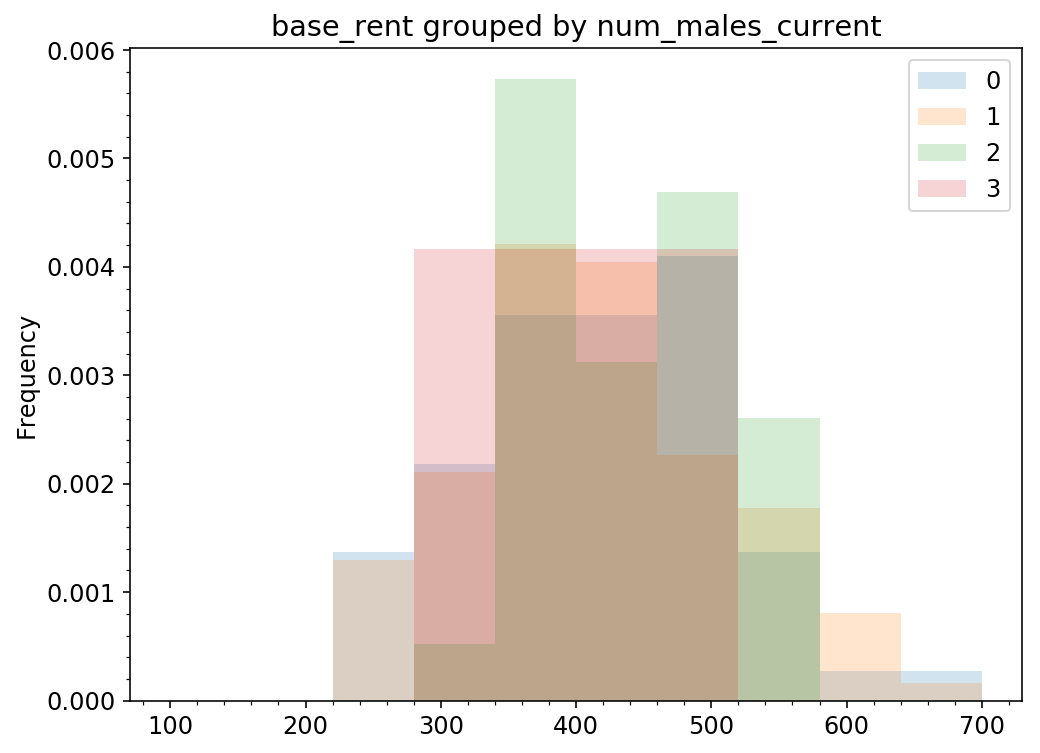

In [66]:
compare_distributions('num_males_current', 'base_rent', 
                      bins=10, range=[100, 700], histtype='stepfilled', alpha=0.2, normed=True)

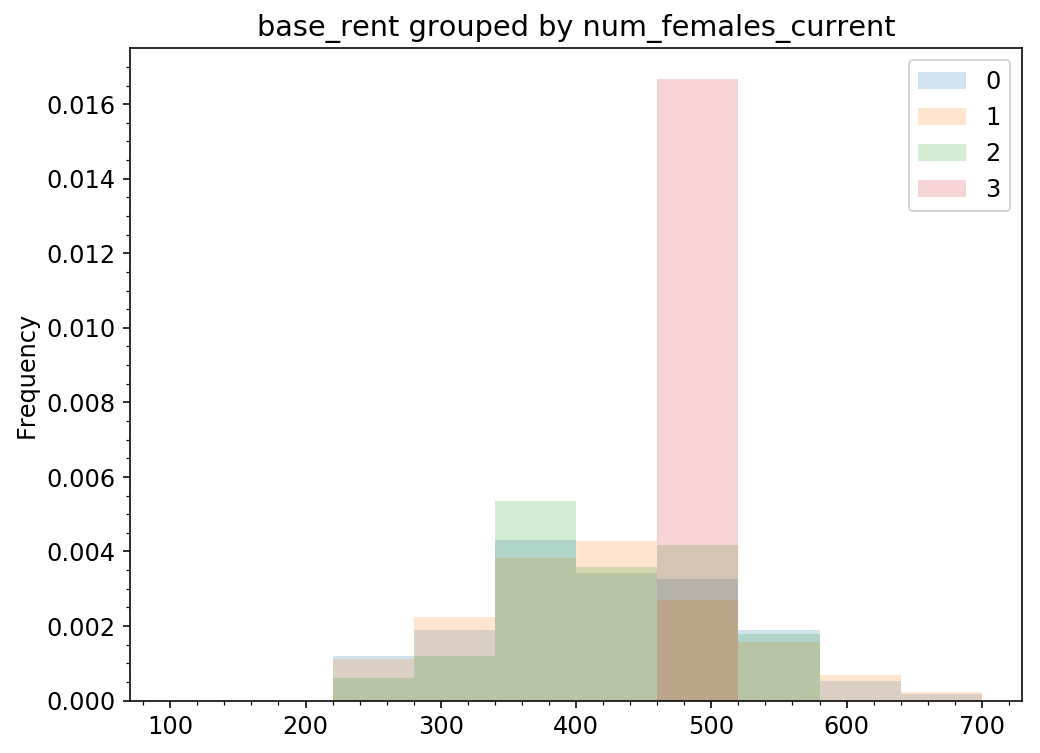

In [67]:
compare_distributions('num_females_current', 'base_rent', 
                      bins=10, range=[100, 700], histtype='stepfilled', alpha=0.2, normed=True)

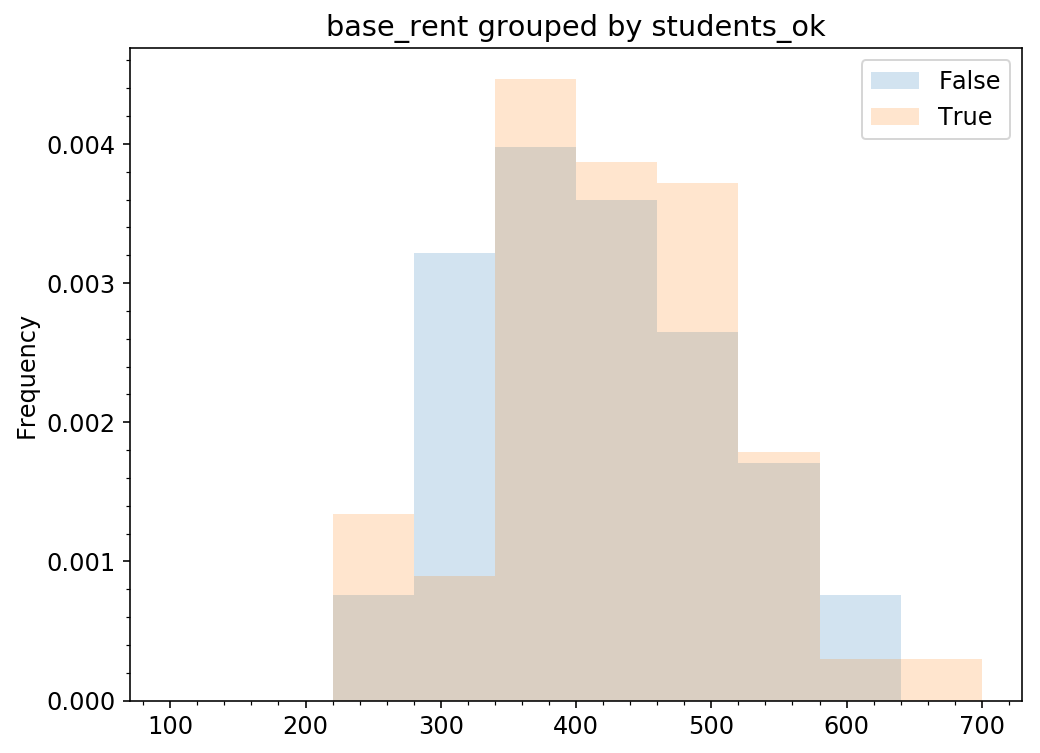

In [68]:
compare_distributions('students_ok', 'base_rent', bins=10, range=[100, 700], normed=True)

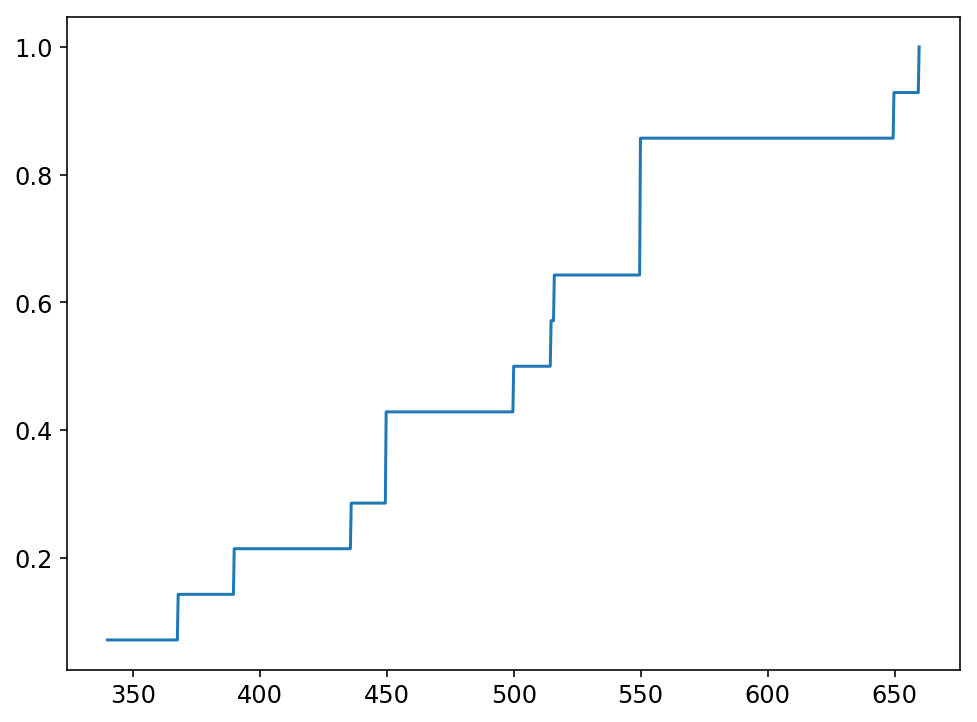

In [69]:
values, bins = np.histogram(df.query('room_area == 20').total_rent.values, bins=1000)
cumul = np.cumsum(values)
plt.plot(bins[:-1], cumul / cumul.max())

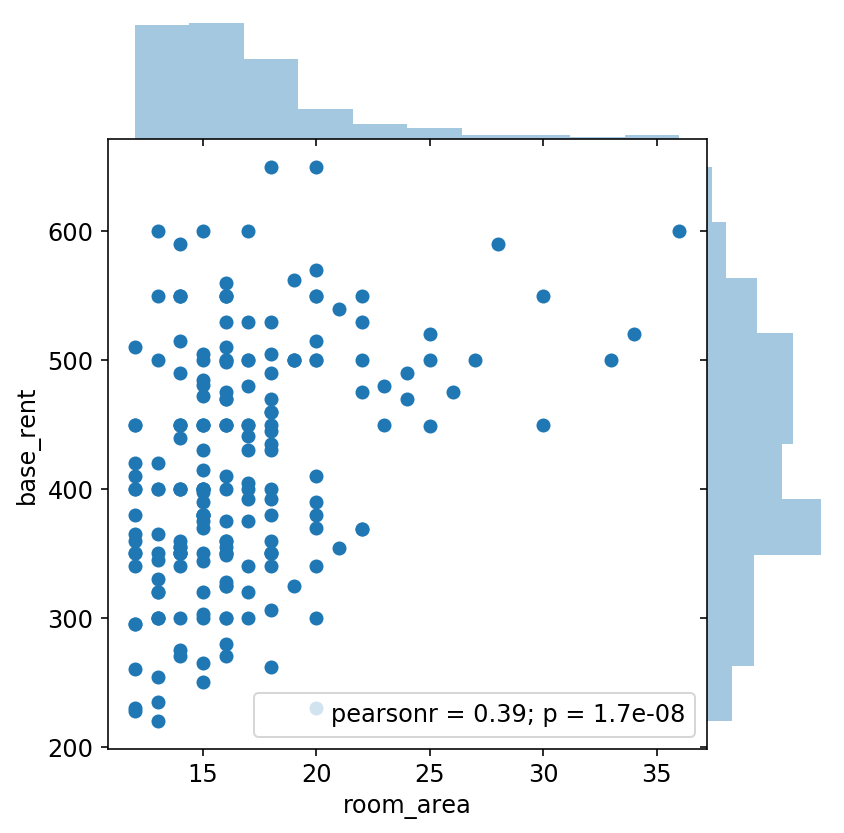

In [70]:
sns.jointplot(x='room_area', y='base_rent', 
              data=df, 
              space=0, marginal_kws={'bins': 10});

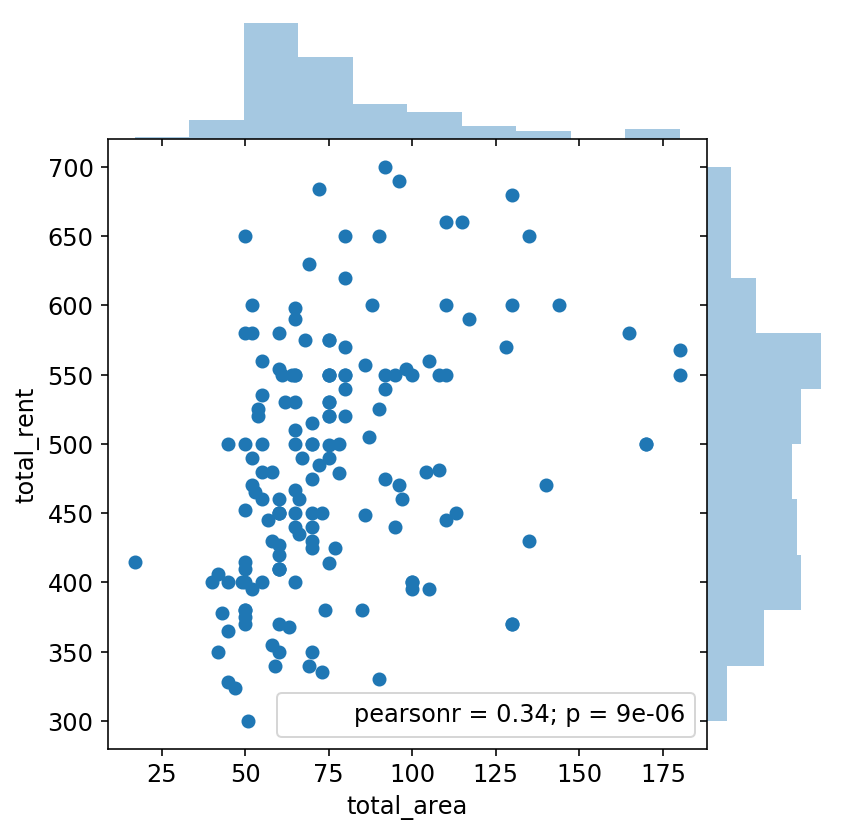

In [164]:
sns.jointplot(x='total_area', y='total_rent', 
              data=df.query('total_area>0'), 
              space=0, marginal_kws={'bins': 10});

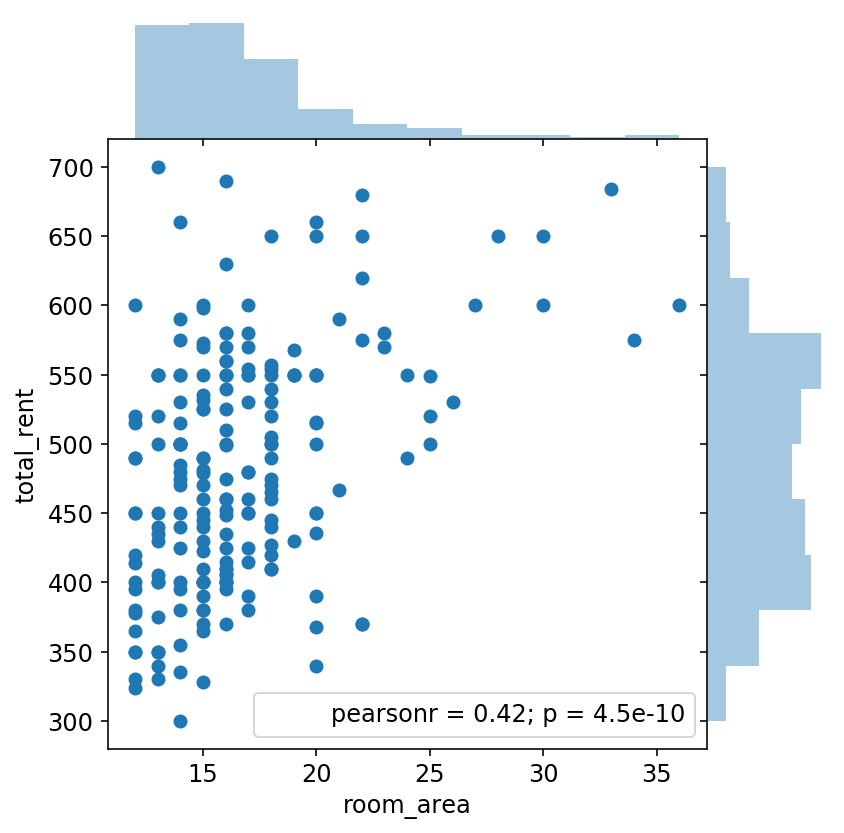

In [72]:
sns.jointplot(x='room_area', y='total_rent', 
              data=df, 
              space=0, marginal_kws={'bins': 10});

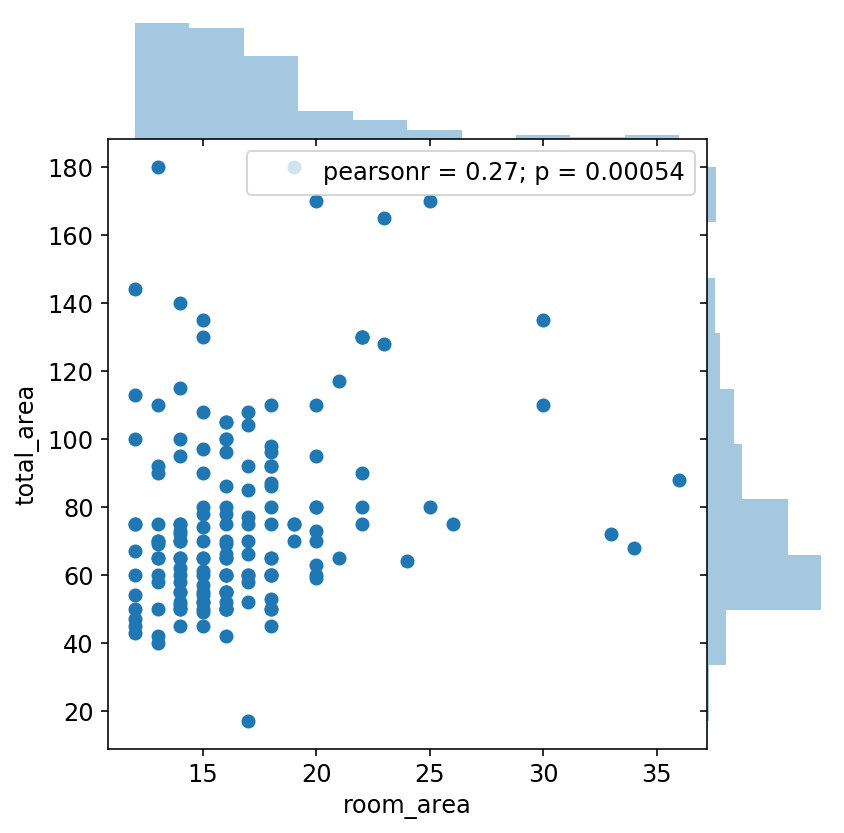

In [73]:
sns.jointplot(x='room_area', y='total_area', 
              data=df.query('total_area>0'), 
              space=0, marginal_kws={'bins': 10});

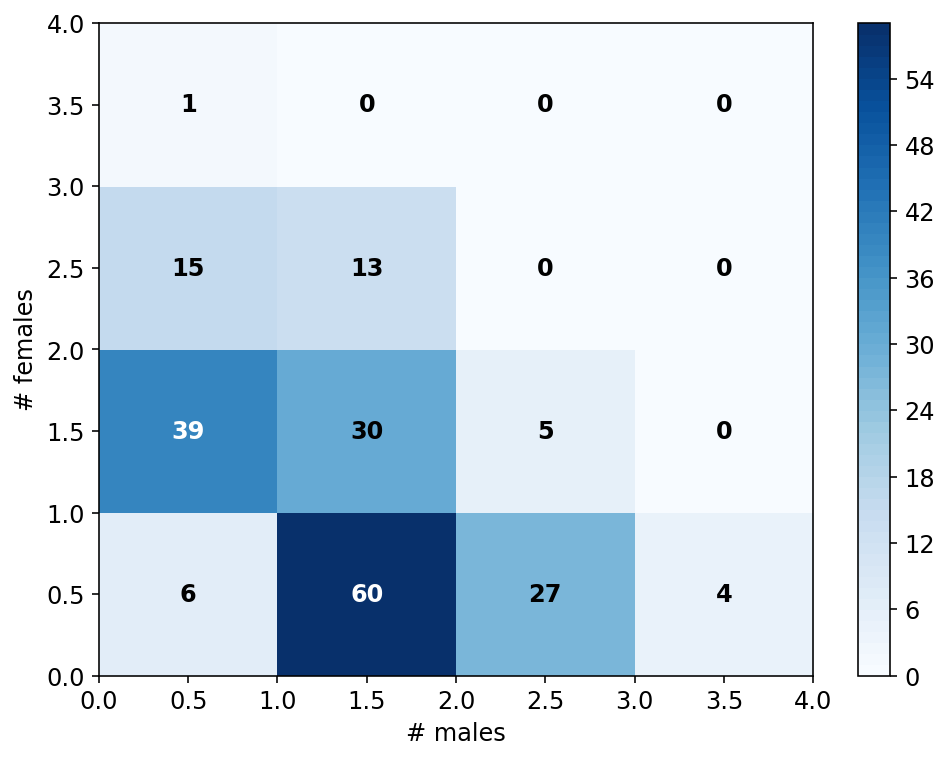

In [123]:
n_person = 5
vals, xbins, ybins = np.histogram2d(df.num_males_current, df.num_females_current,
                                    bins=[range(n_person), range(n_person)])
maxz = int(vals.max())
hist, xbins, ybins, im = plt.hist2d(df.num_males_current, df.num_females_current,
                                    bins=[range(n_person), range(n_person)],
                                    norm=colors.BoundaryNorm(boundaries=range(maxz), ncolors=256), 
                                    cmap='Blues');
for i in range(len(ybins)-1):
    for j in range(len(xbins)-1):
        hist[i,j] = int(hist[i,j])
        plt.text(xbins[j]+0.5,ybins[i]+0.5, "%d" % hist[j,i], 
                 color="w" if hist[j,i] > maxz*(5./8) else 'k', 
                 ha="center", va="center", fontweight="bold")

plt.xlabel('# males')
plt.ylabel('# females')
plt.colorbar();

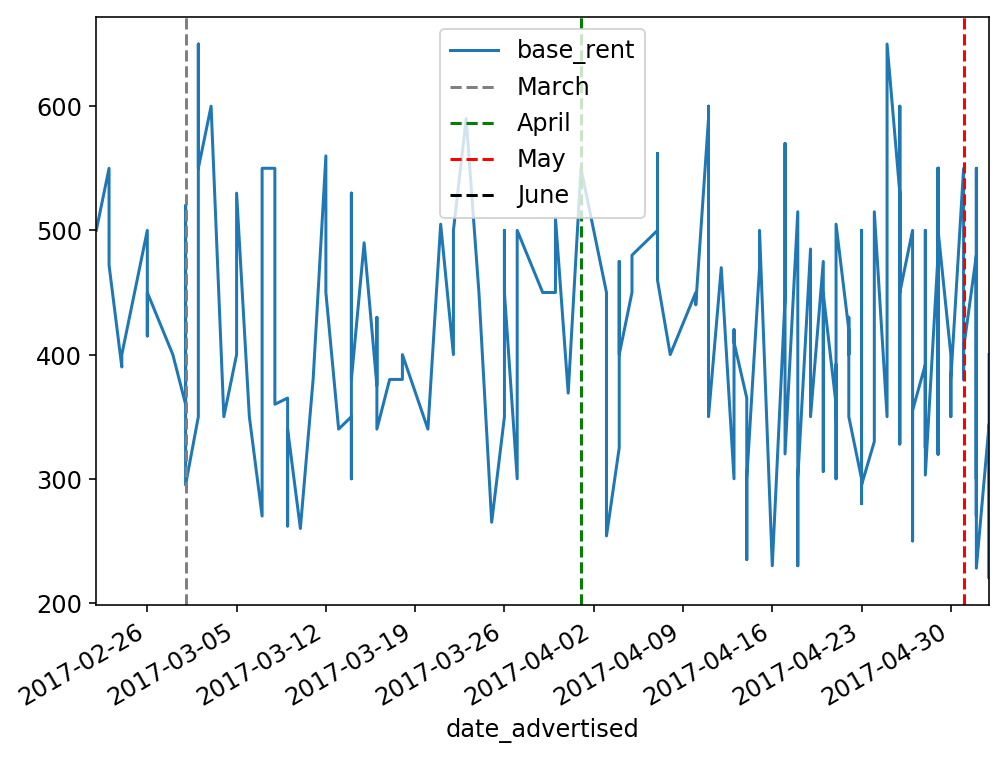

In [176]:
df.plot(x='date_advertised', y='base_rent');
plt.axvline('2017-03-01', c='grey', linestyle='dashed', label='March');
plt.axvline('2017-04-01', c='green', linestyle='dashed', label='April');
plt.axvline('2017-05-01', c='red', linestyle='dashed', label='May');
plt.axvline('2017-06-01', c='black', linestyle='dashed', label='June');
plt.legend();

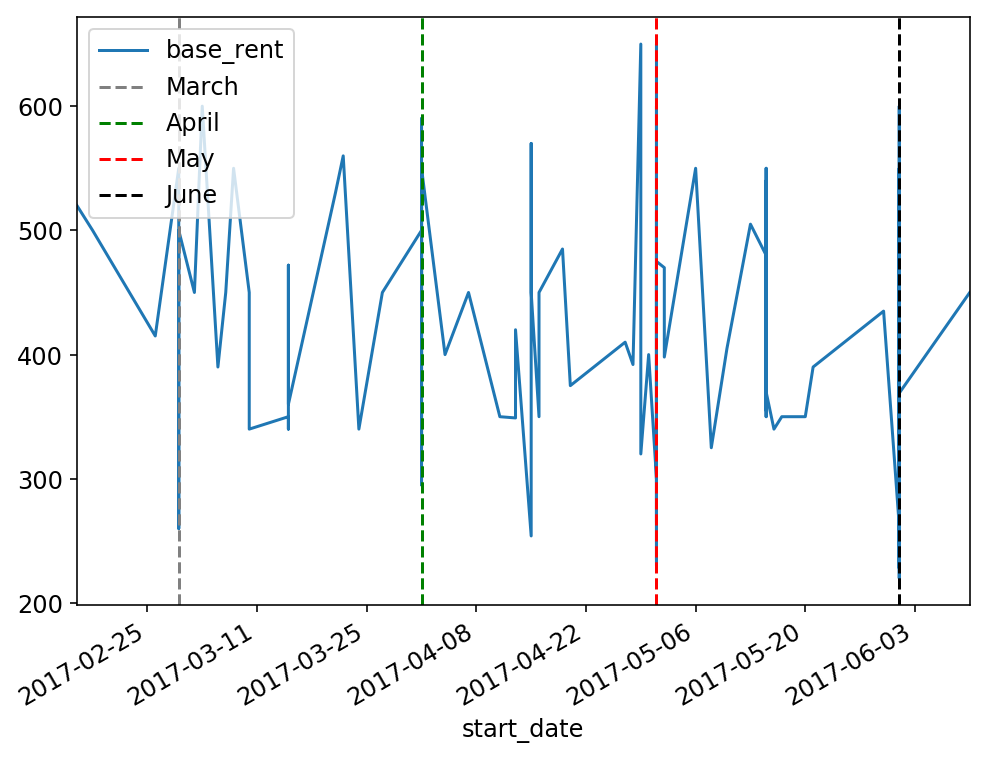

In [177]:
df.plot(x='start_date', y='base_rent');
plt.axvline('2017-03-01', c='grey', linestyle='dashed', label='March');
plt.axvline('2017-04-01', c='green', linestyle='dashed', label='April');
plt.axvline('2017-05-01', c='red', linestyle='dashed', label='May');
plt.axvline('2017-06-01', c='black', linestyle='dashed', label='June');
plt.legend();

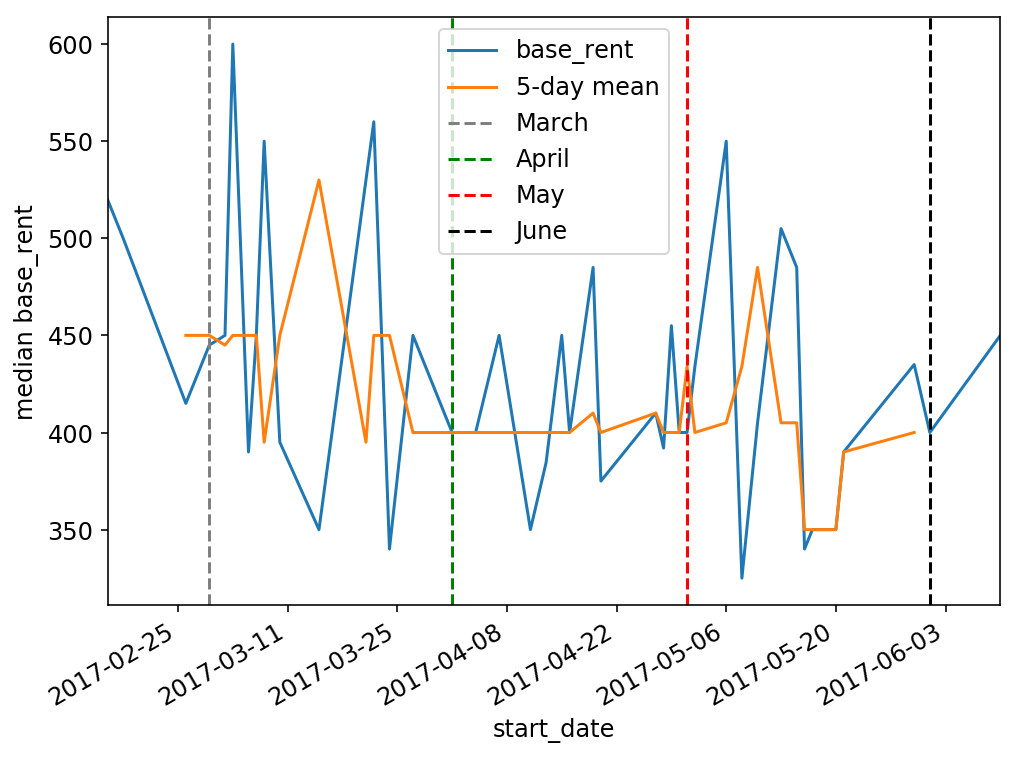

In [182]:
day_ave = df.groupby('start_date').base_rent.median()
ax = day_ave.plot()
window = 5
rolling = day_ave.rolling(window, center=True).median()
rolling.index = day_ave.index
rolling.plot(ax=ax, label="%d-day mean" % window)
plt.axvline('2017-03-01', c='grey', linestyle='dashed', label='March');
plt.axvline('2017-04-01', c='green', linestyle='dashed', label='April');
plt.axvline('2017-05-01', c='red', linestyle='dashed', label='May');
plt.axvline('2017-06-01', c='black', linestyle='dashed', label='June');
plt.ylabel('median base_rent');
plt.legend();

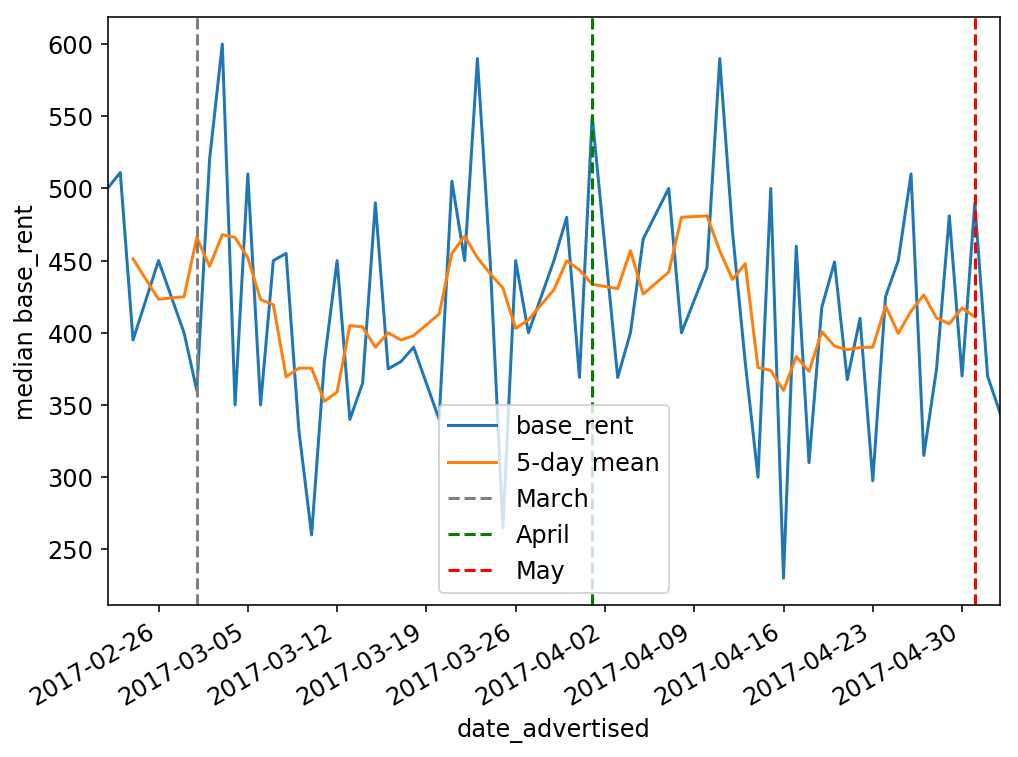

In [181]:
day_ave = df.groupby('date_advertised').base_rent.median()
ax = day_ave.plot()
window = 5
rolling = day_ave.rolling(window, center=True).mean()
rolling.index = day_ave.index
rolling.plot(ax=ax, label="%d-day mean" % window)
plt.axvline('2017-03-01', c='grey', linestyle='dashed', label='March');
plt.axvline('2017-04-01', c='green', linestyle='dashed', label='April');
plt.axvline('2017-05-01', c='red', linestyle='dashed', label='May');
# plt.axvline('2017-06-01', c='black', linestyle='dashed', label='June');
plt.ylabel('median base_rent');
plt.legend();

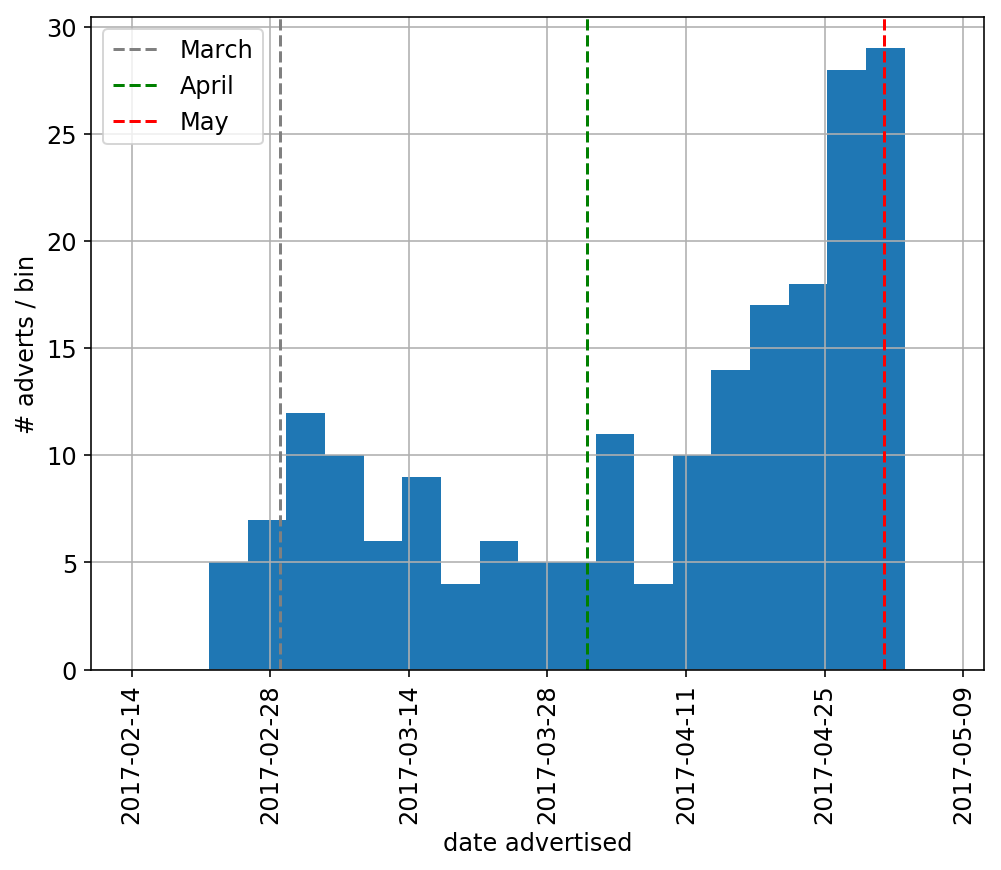

In [184]:
df.date_advertised.hist(bins=21, xrot=90, range=['2017-02-14', '2017-05-07']);
plt.ylabel('# adverts / bin')
plt.axvline('2017-03-01', c='grey', linestyle='dashed', label='March');
plt.axvline('2017-04-01', c='green', linestyle='dashed', label='April');
plt.axvline('2017-05-01', c='red', linestyle='dashed', label='May');
# plt.axvline('2017-06-01', c='black', linestyle='dashed', label='June');
plt.xlabel("date advertised")
plt.legend();

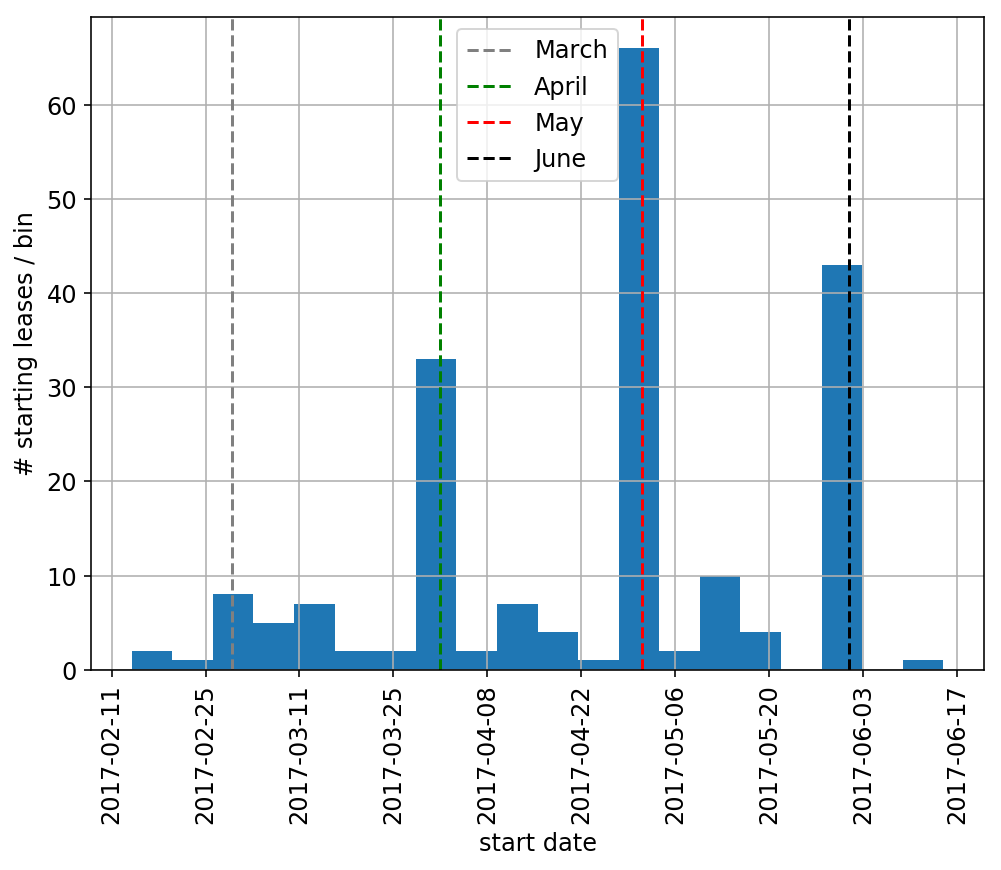

In [185]:
df.start_date.hist(bins=20, xrot=90, range=['2017-02-14', '2017-06-15']);
plt.ylabel('# starting leases / bin')
plt.axvline('2017-03-01', c='grey', linestyle='dashed', label='March');
plt.axvline('2017-04-01', c='green', linestyle='dashed', label='April');
plt.axvline('2017-05-01', c='red', linestyle='dashed', label='May');
plt.axvline('2017-06-01', c='black', linestyle='dashed', label='June');
plt.xlabel("start date");
plt.legend();

In [79]:
df.start_date.value_counts().head()

2017-05-01    58
2017-06-01    42
2017-04-01    33
2017-05-15     8
2017-03-15     7
Name: start_date, dtype: int64

In [80]:
lag = df.start_date - df.date_advertised

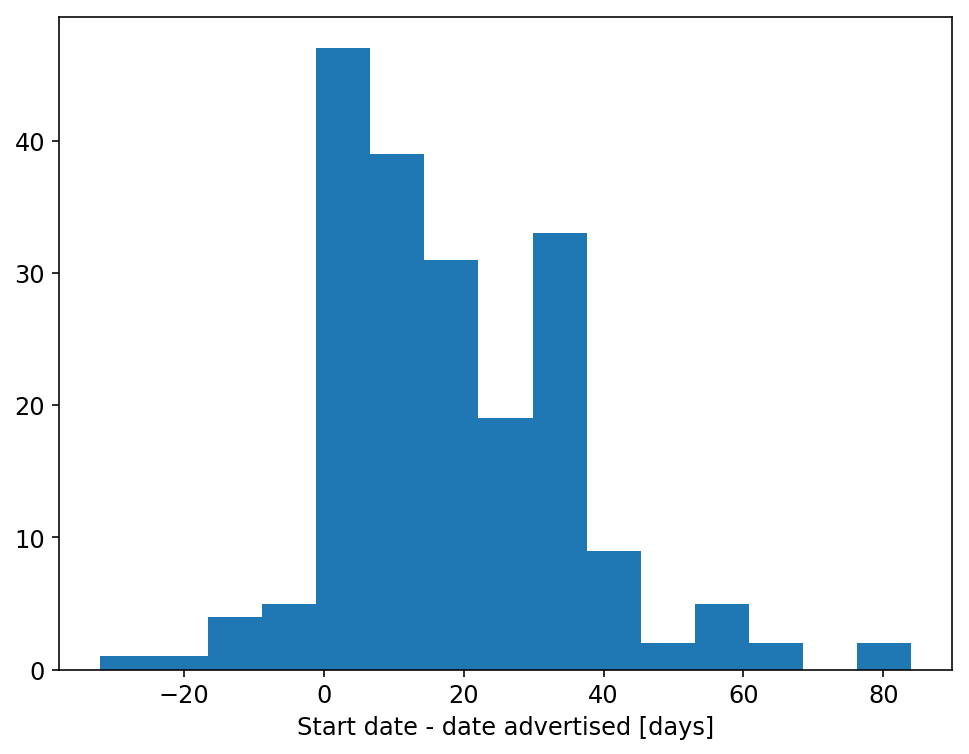

In [81]:
plt.hist(lag / pd.Timedelta(days=1), bins=15);
plt.xlabel("Start date - date advertised [days]");

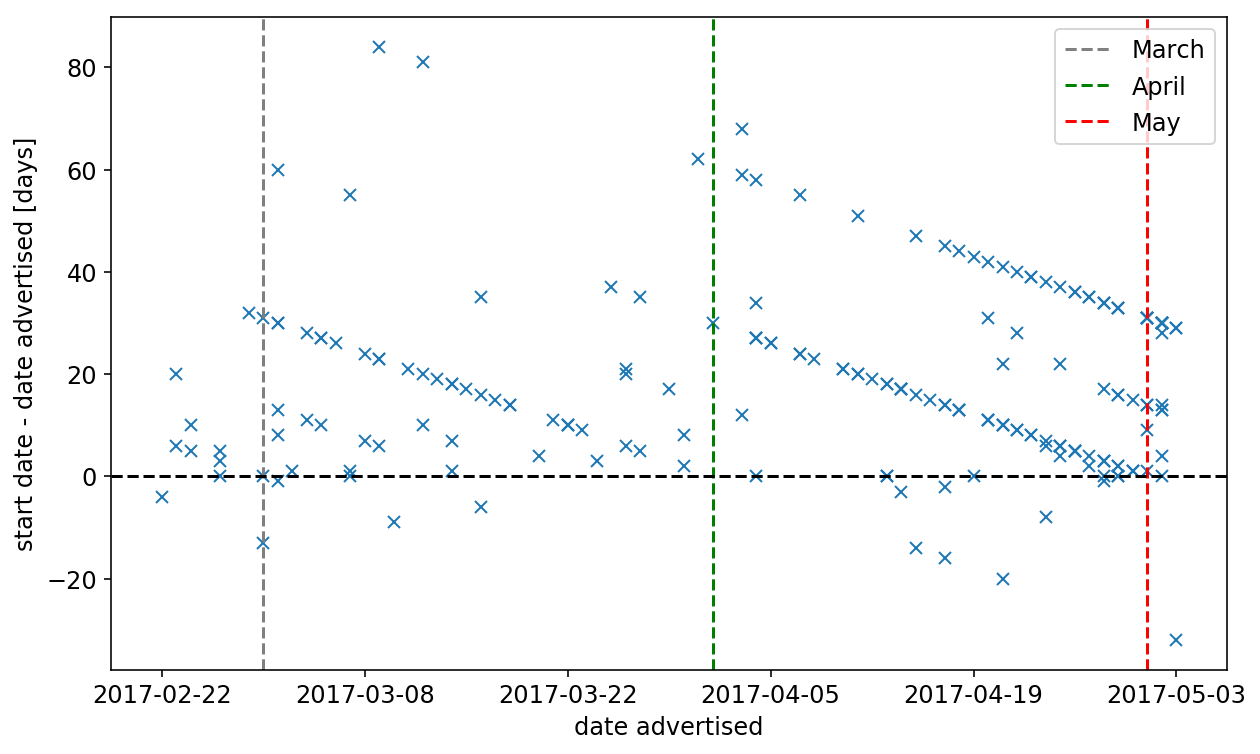

In [186]:
plt.plot(df.date_advertised, lag / pd.Timedelta(days=1), 'x')
plt.xlabel('date advertised');
plt.ylabel('start date - date advertised [days]');
plt.gcf().set_size_inches(10, 6);
plt.axvline('2017-03-01', c='grey', linestyle='dashed', label='March');
plt.axvline('2017-04-01', c='green', linestyle='dashed', label='April');
plt.axvline('2017-05-01', c='red', linestyle='dashed', label='May');
# plt.axvline('2017-06-01', c='black', linestyle='dashed', label='June');
plt.legend();
plt.axhline(0, c='black', linestyle='dashed');

In [83]:
df.groupby('total_occupancy').base_rent.describe()

total_occupancy       
2                count    101.000000
                 mean     409.316832
                 std       98.411171
                 min      228.000000
                 25%      350.000000
                 50%      400.000000
                 75%      475.000000
                 max      650.000000
3                count     74.000000
                 mean     425.405405
                 std       89.493693
                 min      220.000000
                 25%      350.000000
                 50%      427.500000
                 75%      500.000000
                 max      600.000000
4                count     25.000000
                 mean     425.840000
                 std       76.733674
                 min      320.000000
                 25%      355.000000
                 50%      400.000000
                 75%      500.000000
                 max      562.000000
Name: base_rent, dtype: float64

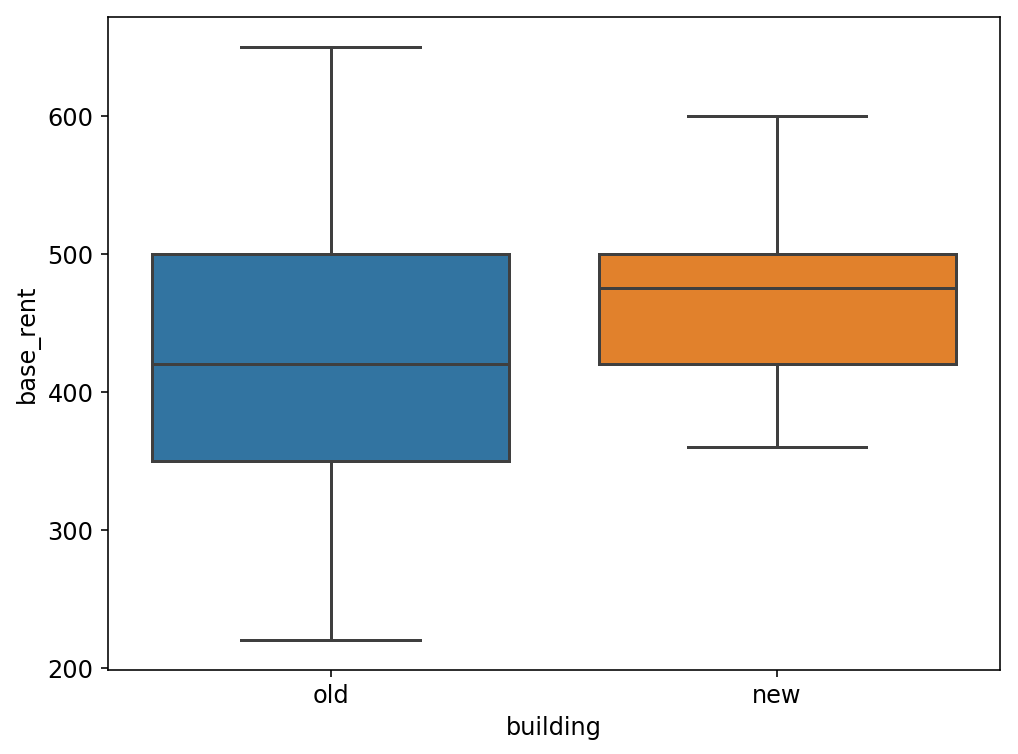

In [115]:
sns.boxplot(y='base_rent', x='building', data=df);

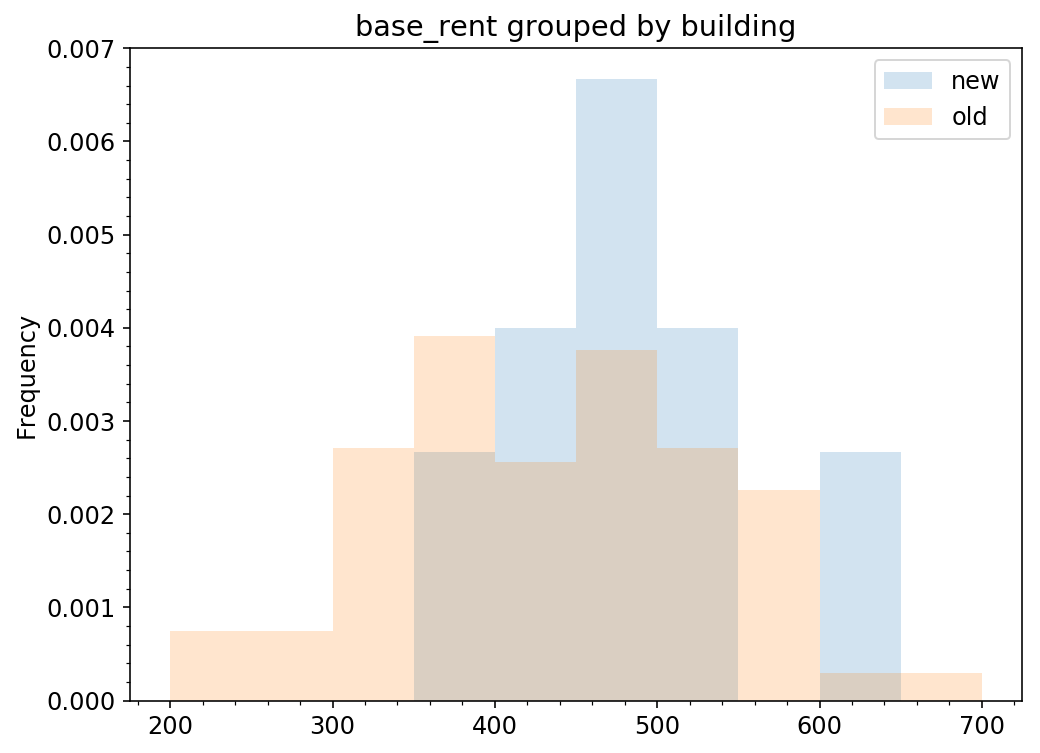

In [118]:
compare_distributions('building', 'base_rent', bins=10, range=[200, 700], normed=True)

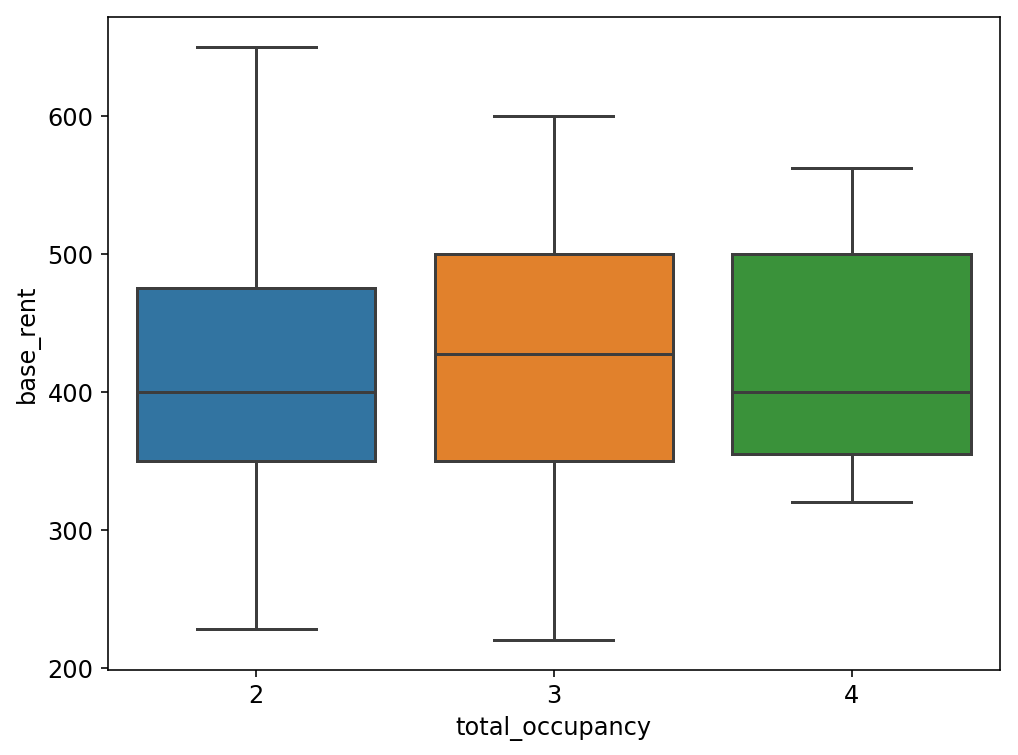

In [84]:
sns.boxplot(y='base_rent', x='total_occupancy', data=df);

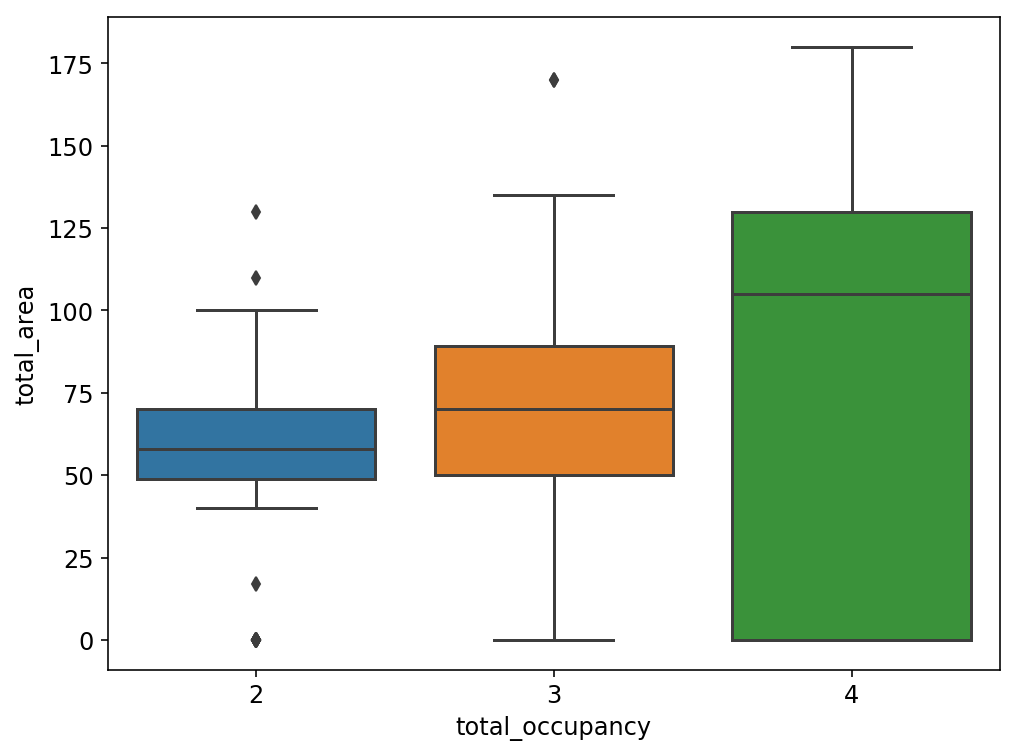

In [85]:
sns.boxplot(y='total_area', x='total_occupancy', data=df);

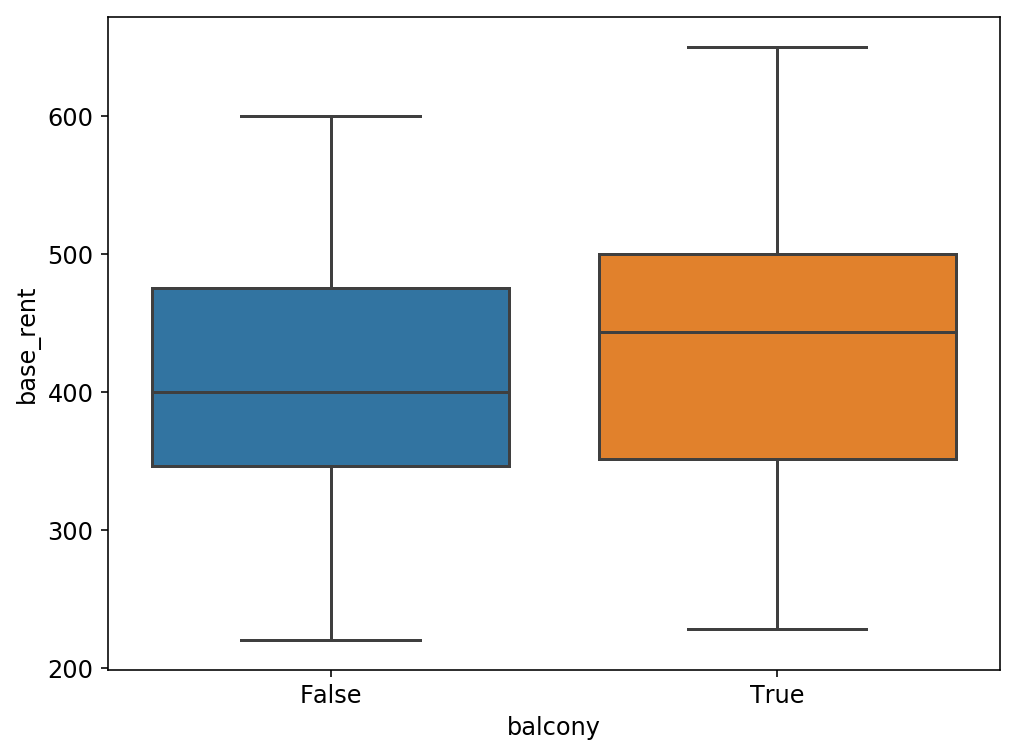

In [86]:
sns.boxplot(y='base_rent', x='balcony', data=df);

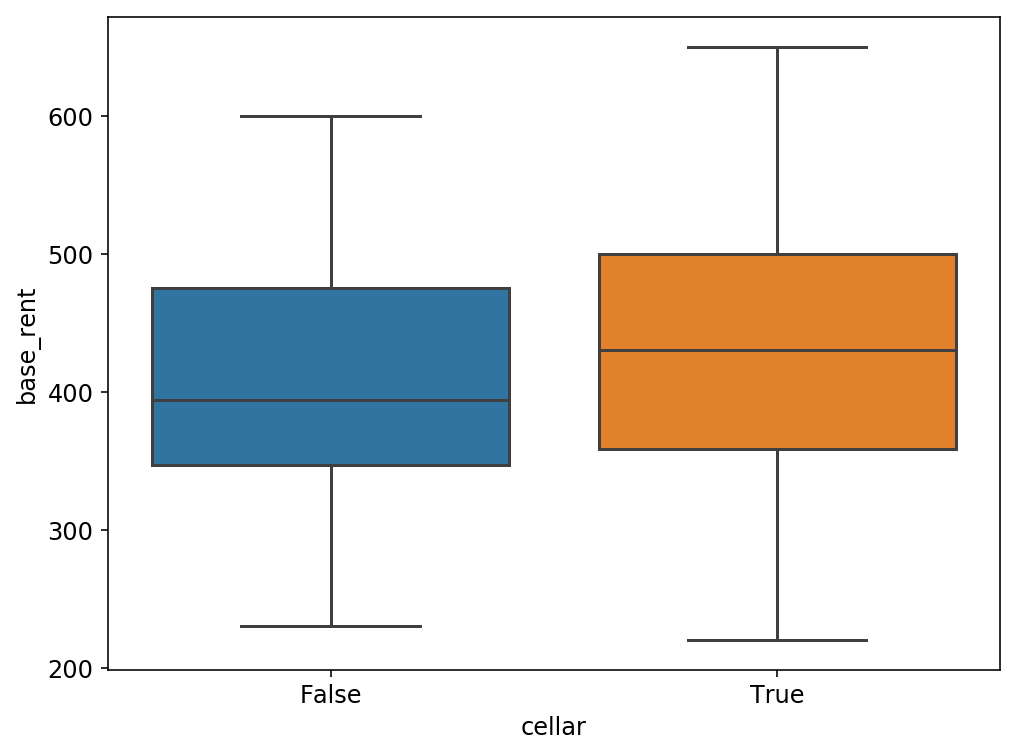

In [87]:
sns.boxplot(y='base_rent', x='cellar', data=df);

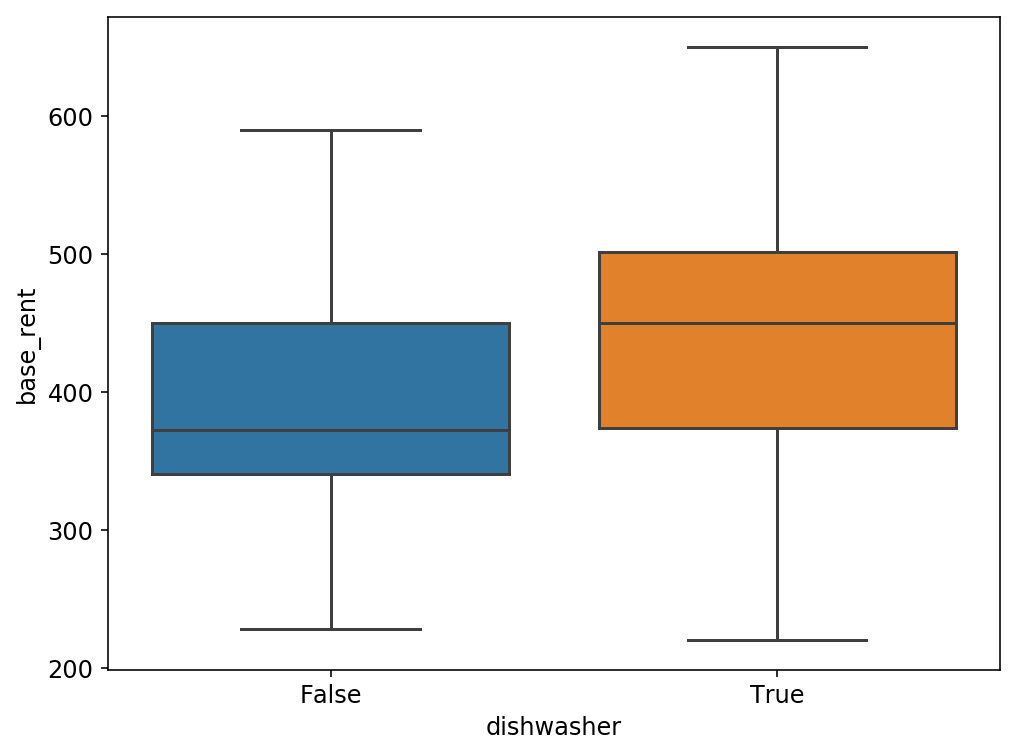

In [88]:
sns.boxplot(y='base_rent', x='dishwasher', data=df);

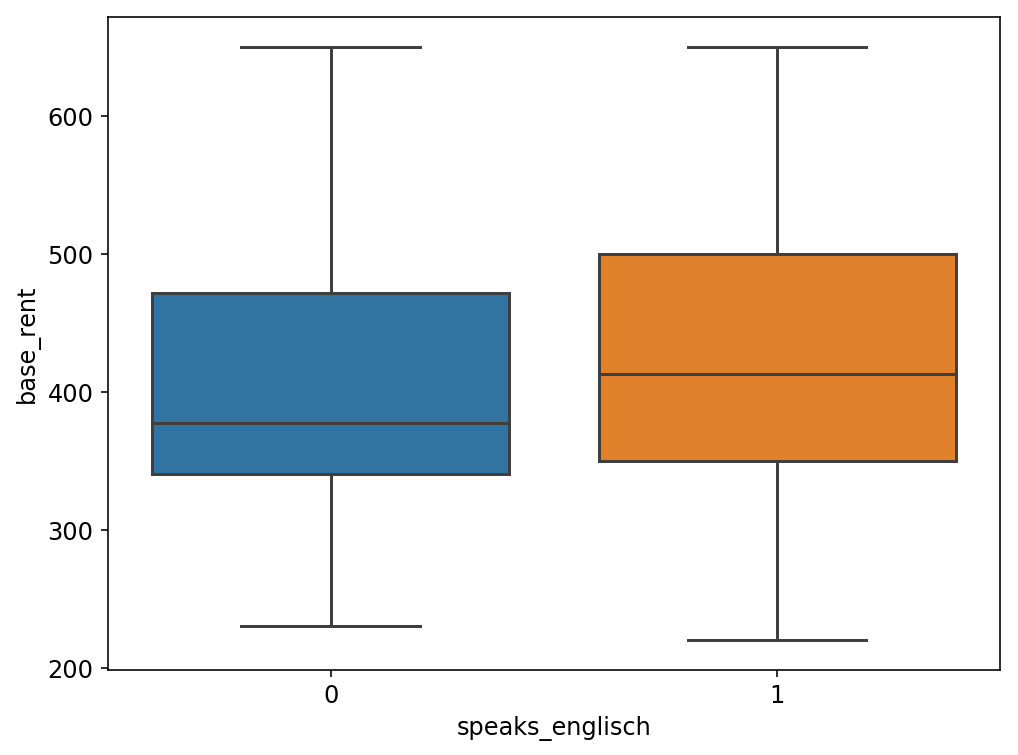

In [89]:
sns.boxplot(y='base_rent', x='speaks_englisch', data=df);

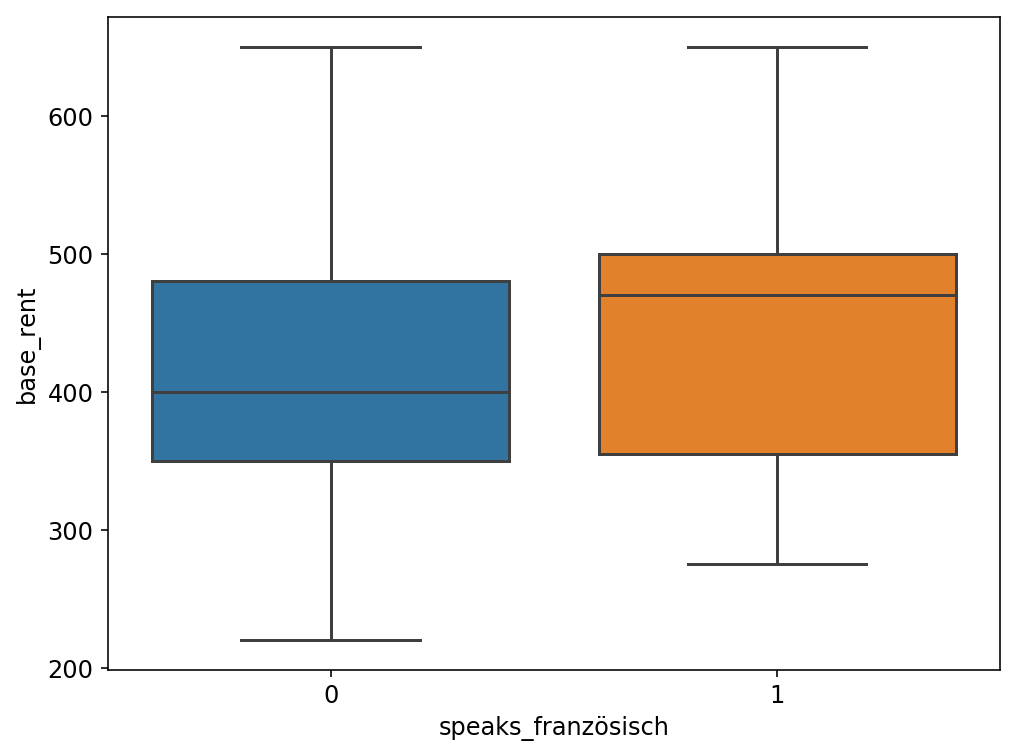

In [90]:
sns.boxplot(y='base_rent', x='speaks_französisch', data=df);

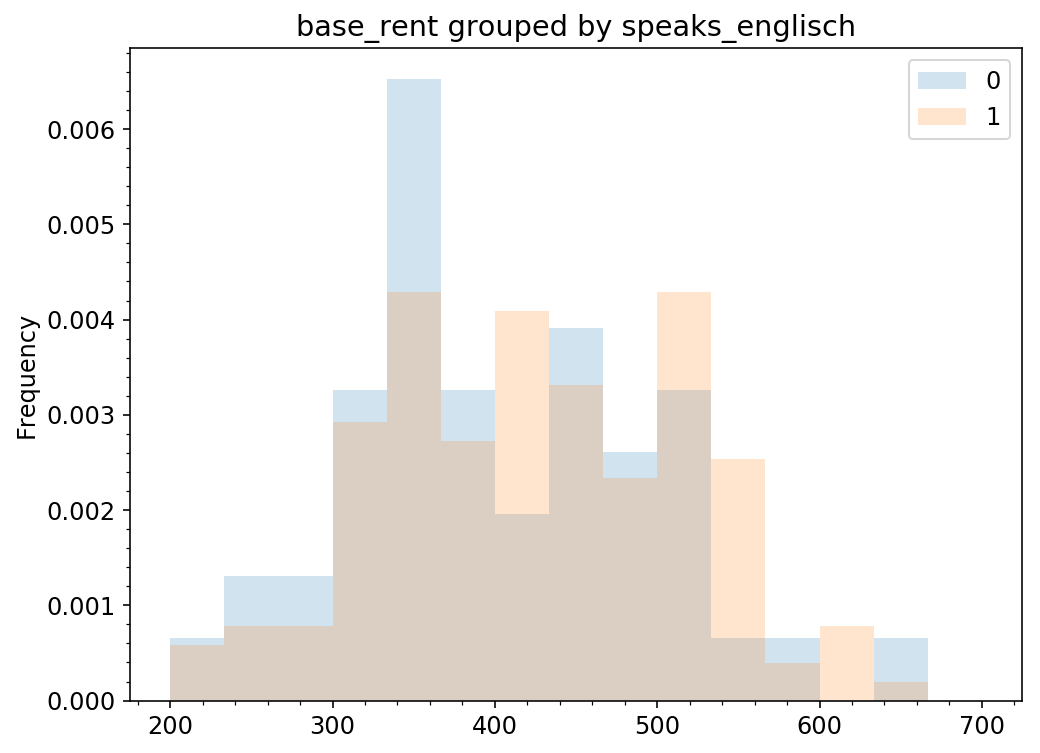

In [91]:
compare_distributions('speaks_englisch', 'base_rent', normed=True, bins=15, range=[200, 700])

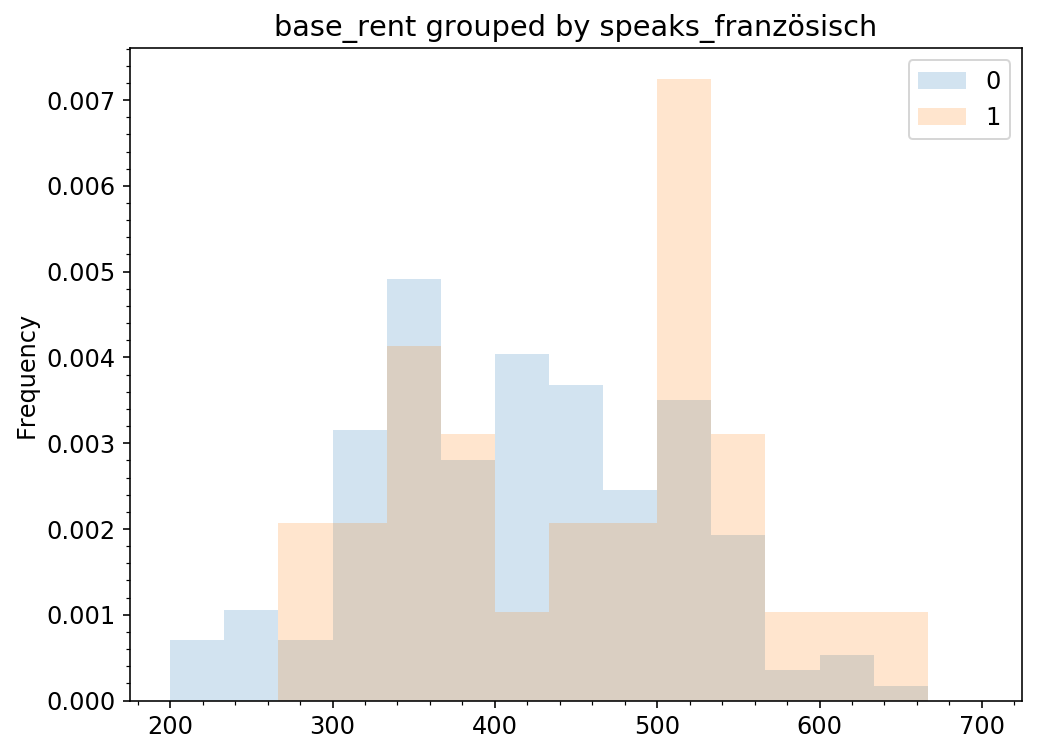

In [92]:
compare_distributions('speaks_französisch', 'base_rent', normed=True, bins=15, range=[200, 700])

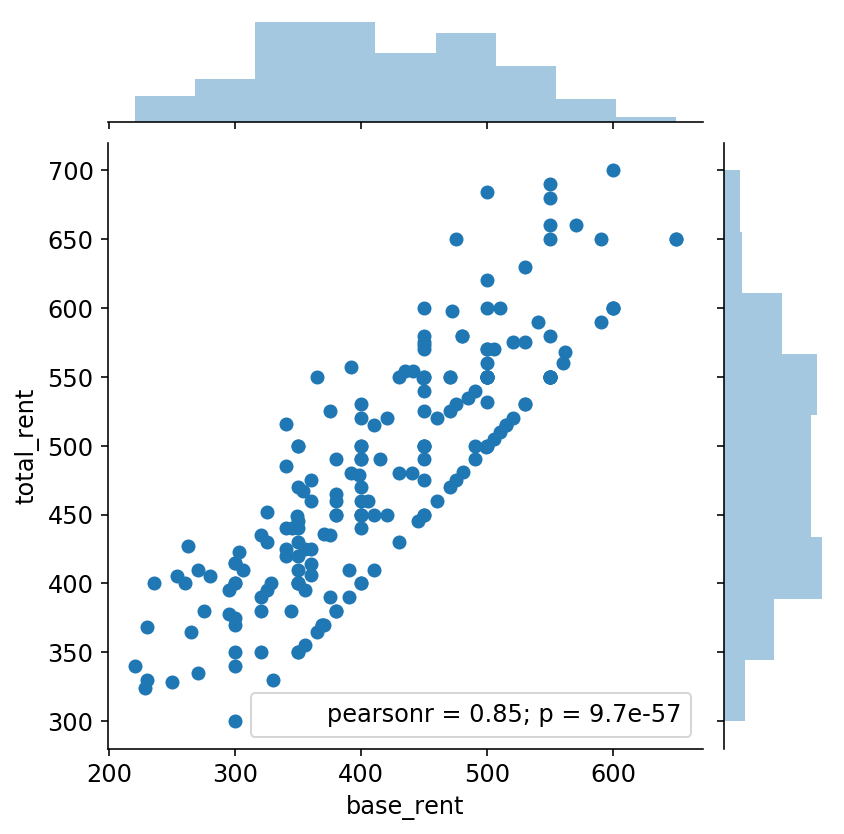

In [93]:
sns.jointplot(x='base_rent', y='total_rent', data=df);
# df.plot.scatter(x='base_rent', y='total_rent');

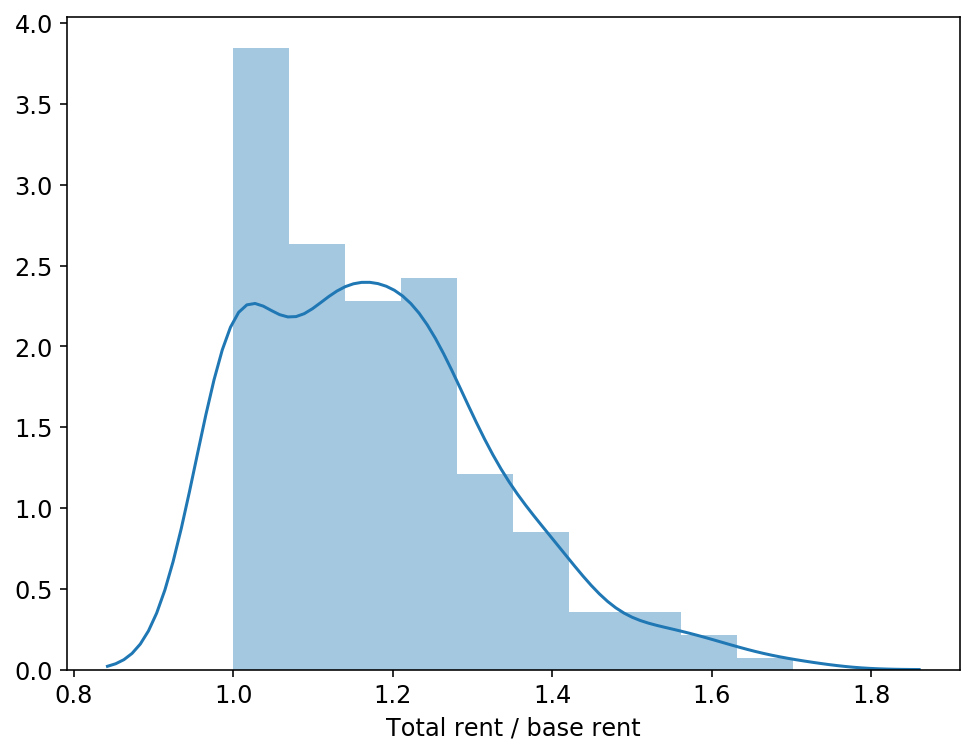

In [94]:
sns.distplot(df.total_rent/df.base_rent);
plt.xlabel("Total rent / base rent");

In [95]:
df.groupby('students_ok').describe(percentiles=[])

base_rent  current_max_age  current_min_age      deposit  \
students_ok                                                                    
False       count   88.000000        88.000000        88.000000    88.000000   
            mean   412.215909        19.420455        16.034091   648.818182   
            std     92.620899        15.947271        12.629512   444.380456   
            min    235.000000        -1.000000        -1.000000     0.000000   
            50%    400.000000        24.000000        21.000000   650.000000   
            max    600.000000        77.000000        60.000000  1710.000000   
True        count  112.000000       112.000000       112.000000   112.000000   
            mean   421.357143        24.875000        19.178571   730.500000   
            std     92.858398        18.376015        13.243536   392.254629   
            min    220.000000        -1.000000        -1.000000     0.000000   
            50%    412.500000        28.000000        24.000000   700.000000   
            max    650.000000        89.000000        49.000000  1600.000000   

                   desired_max_age  desired_min_age    distance  \
students_ok                                                       
False       count        88.000000        88.000000   88.000000   
            mean         24.068182        13.602273    3.964773   
            std          19.330041         9.919839    1.883506   
            min          -1.000000        -1.000000    0.400000   
            50%          30.000000        18.000000    3.950000   
            max          99.000000        25.000000    6.900000   
True        count       112.000000       112.000000  112.000000   
            mean         30.357143        16.446429    3.822321   
            std          23.962755        10.600730    2.187627   
            min          -1.000000        -1.000000    0.200000   
            50%          33.000000        21.000000    3.650000   
            max          99.000000        26.000000    7.000000   

                   existing_equipment_fees  house_number    latitude  \
students_ok                                                            
False       count                88.000000     88.000000   88.000000   
            mean                 16.704545     28.988636   53.574977   
            std                  61.601642     54.976587    0.016400   
            min                   0.000000     -1.000000   53.536460   
            50%                   0.000000      8.500000   53.575188   
            max                 400.000000    317.000000   53.606849   
True        count               112.000000    112.000000  112.000000   
            mean                 13.357143     33.401786   53.563001   
            std                  53.905466     55.489380    0.019495   
            min                   0.000000     -1.000000   53.511090   
            50%                   0.000000      6.000000   53.564515   
            max                 300.000000    257.000000   53.605209   

                      ...      speaks_norwegisch  speaks_polnisch  \
students_ok           ...                                           
False       count     ...              88.000000        88.000000   
            mean      ...               0.000000         0.000000   
            std       ...               0.000000         0.000000   
            min       ...               0.000000         0.000000   
            50%       ...               0.000000         0.000000   
            max       ...               0.000000         0.000000   
True        count     ...             112.000000       112.000000   
            mean      ...               0.008929         0.017857   
            std       ...               0.094491         0.133027   
            min       ...               0.000000         0.000000   
            50%       ...               0.000000         0.000000   
            max       ...               1.000000      

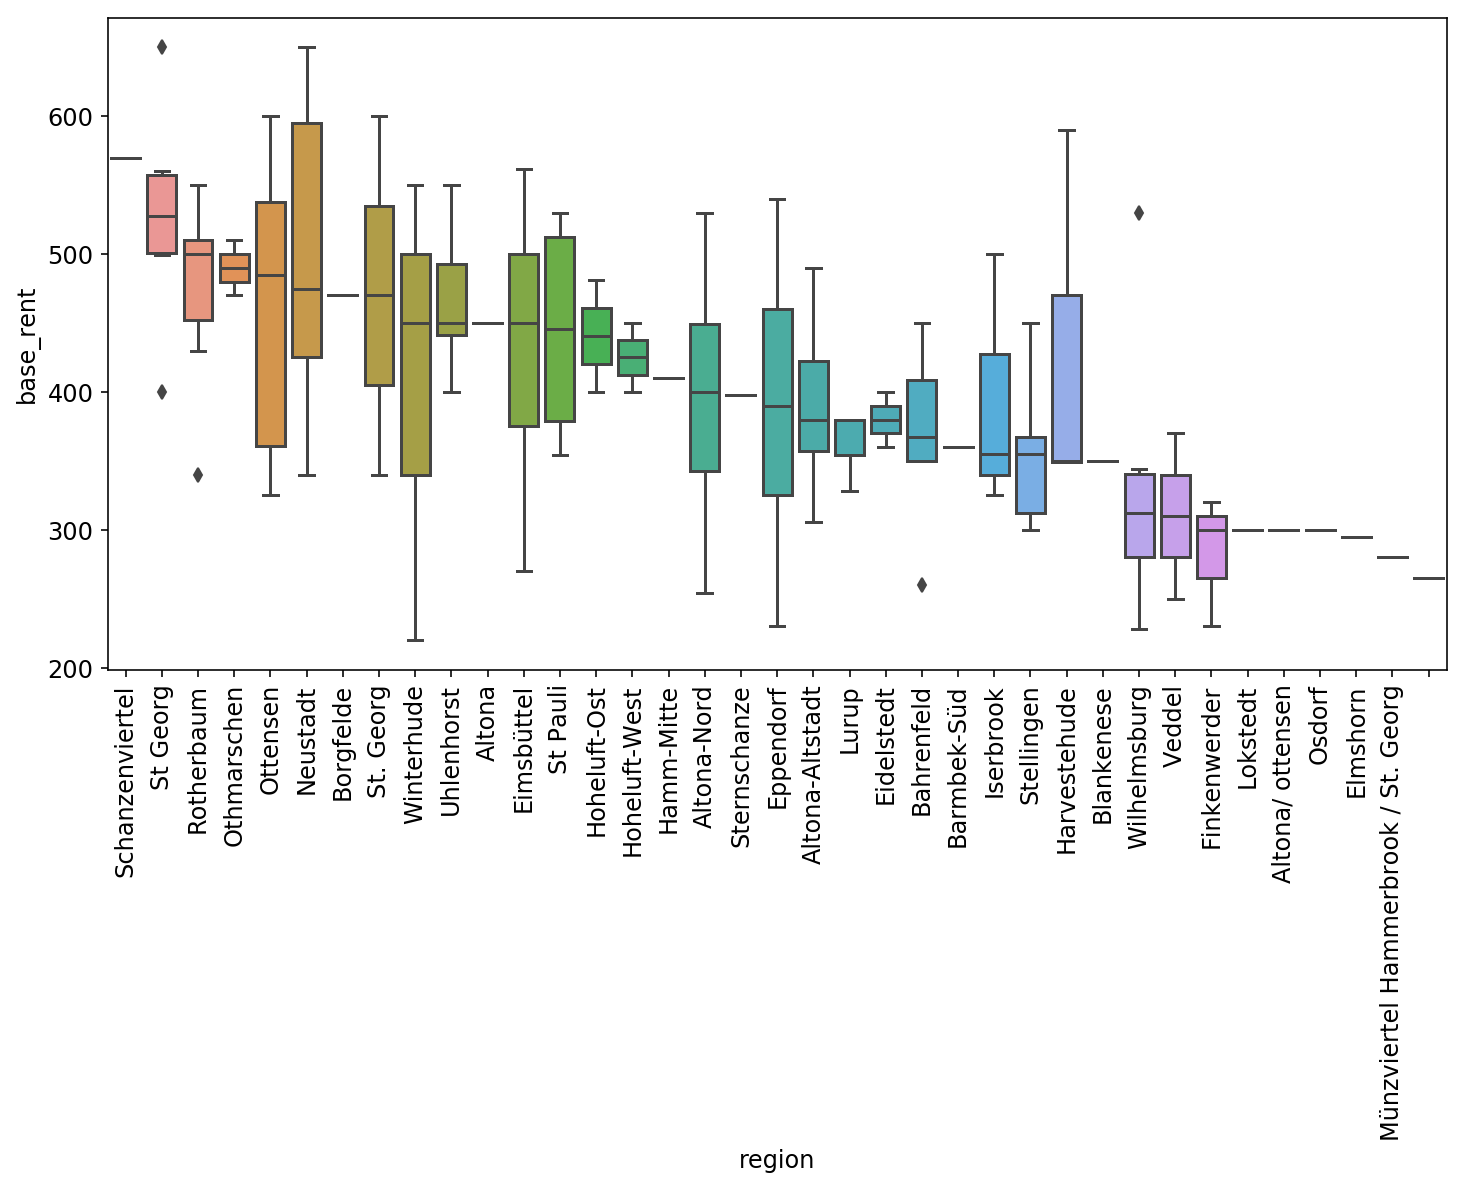

In [96]:
rr = df.groupby('region').base_rent.median().sort_values(ascending=False)
sns.boxplot(y="base_rent", data=df, x="region", order=rr.index);
plt.gcf().set_size_inches(12, 6);
plt.xticks(rotation=90);

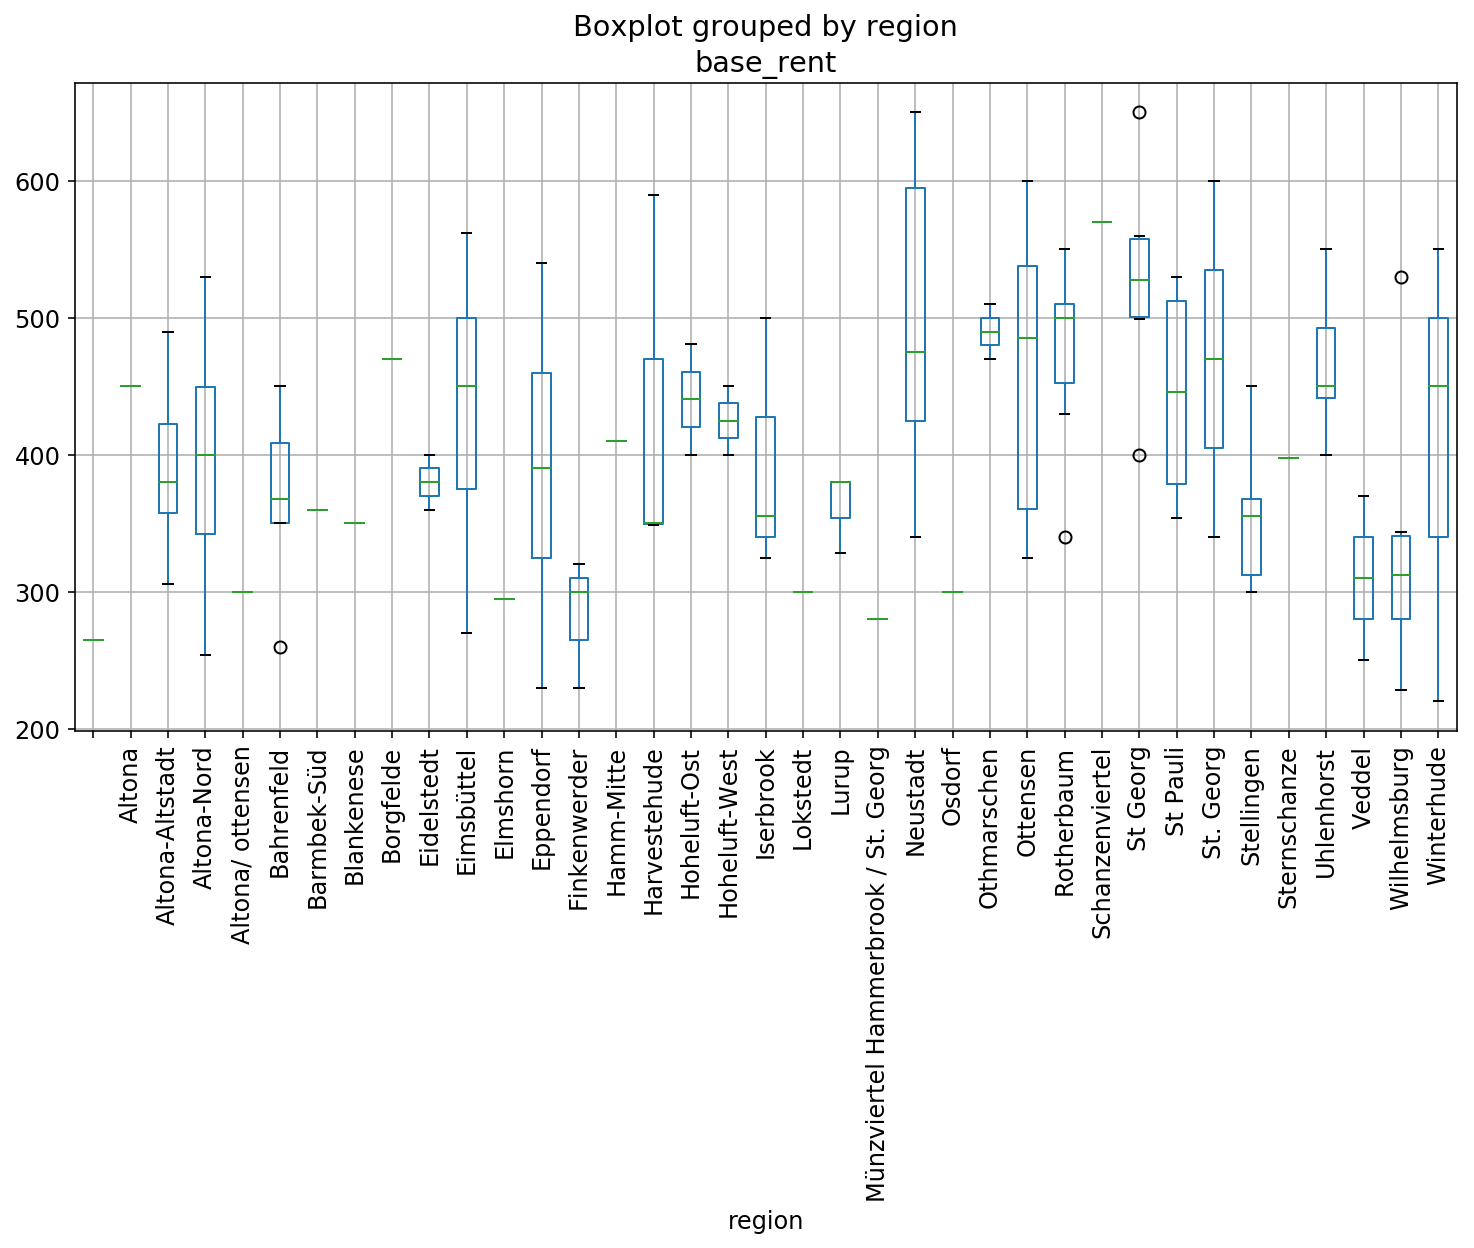

In [97]:
df.boxplot(column='base_rent', by='region', rot=90);
plt.gcf().set_size_inches(12, 6);

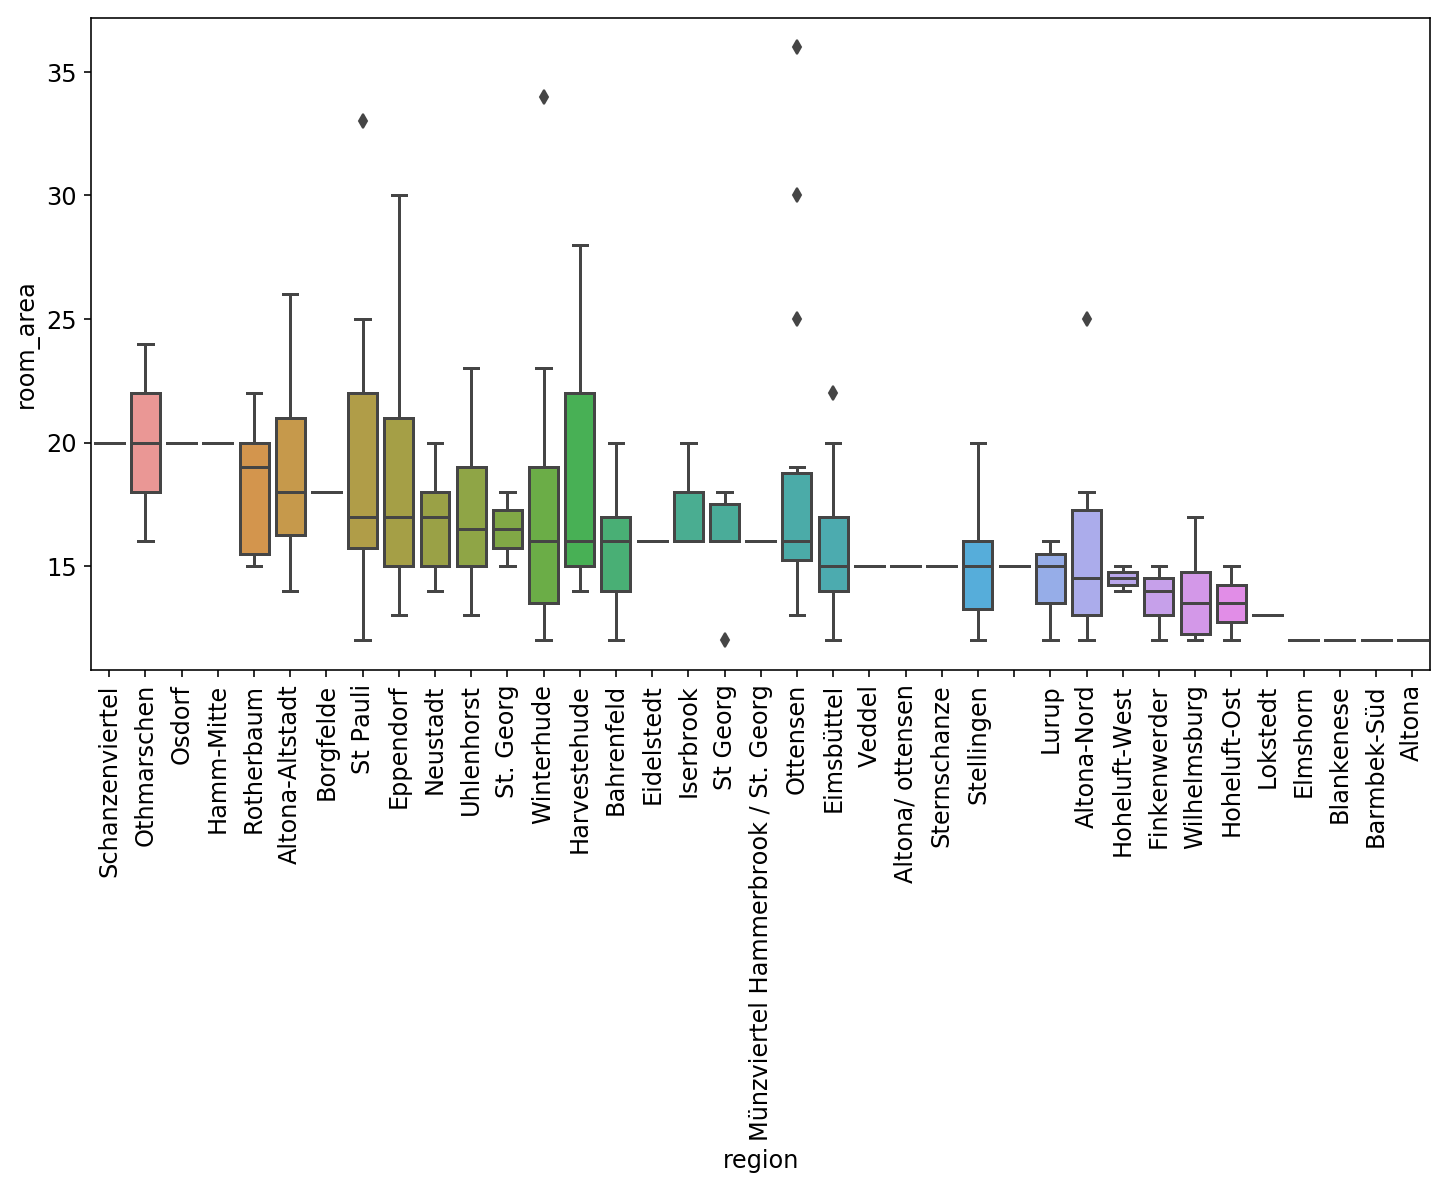

In [98]:
rr = df.groupby('region').room_area.median().sort_values(ascending=False)
sns.boxplot(y="room_area", data=df, x="region", order=rr.index);
plt.gcf().set_size_inches(12, 6);
plt.xticks(rotation=90);

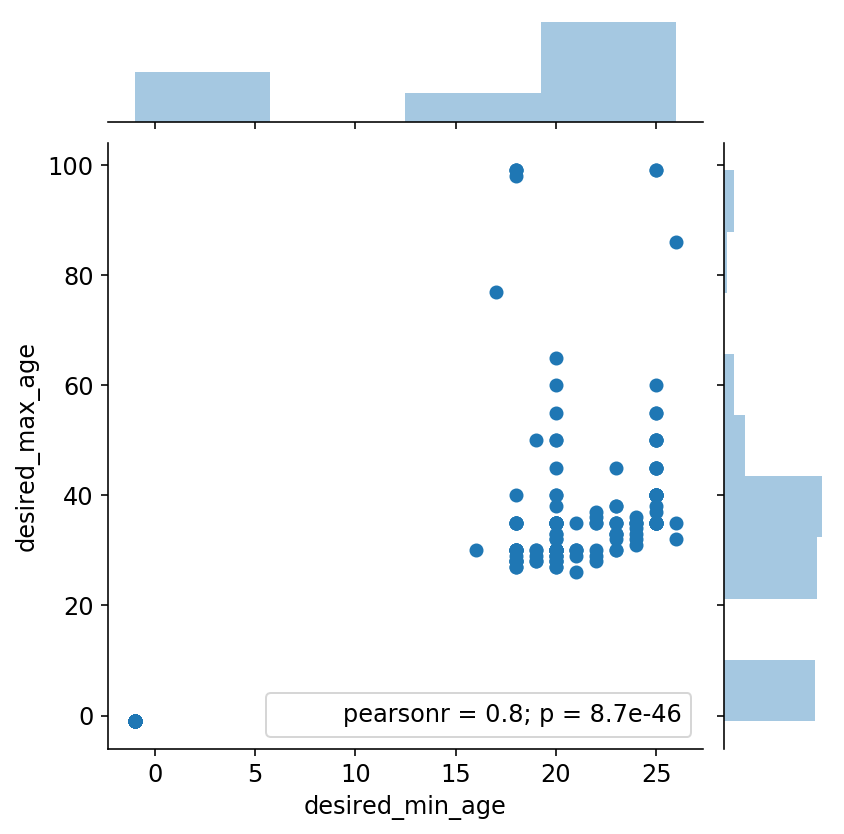

In [102]:
sns.jointplot(x='desired_min_age', y='desired_max_age', data=df);

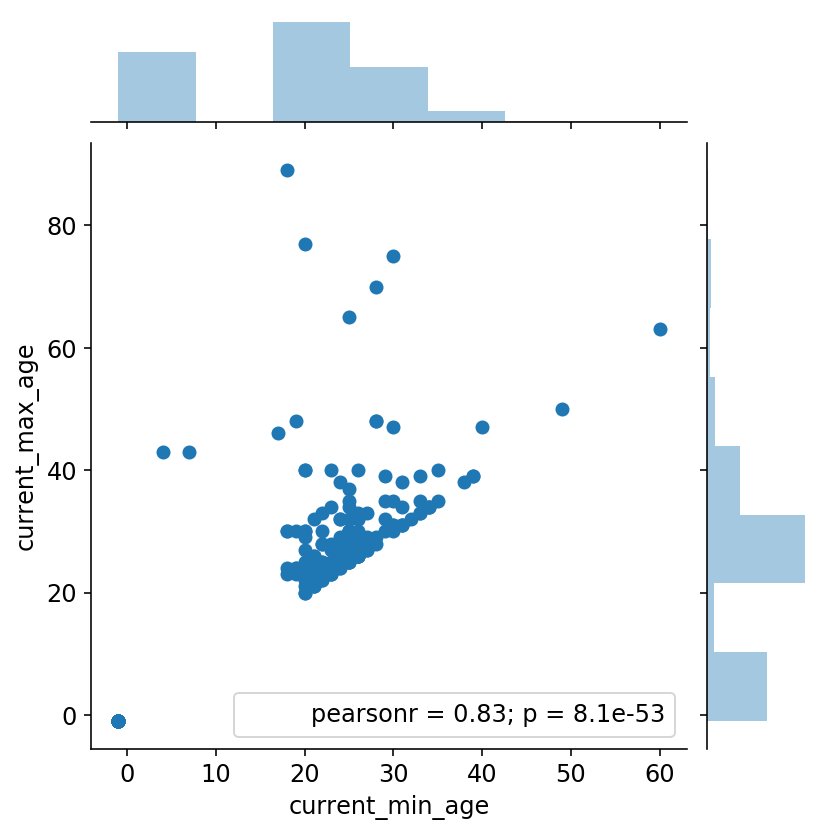

In [103]:
sns.jointplot(x='current_min_age', y='current_max_age', data=df);

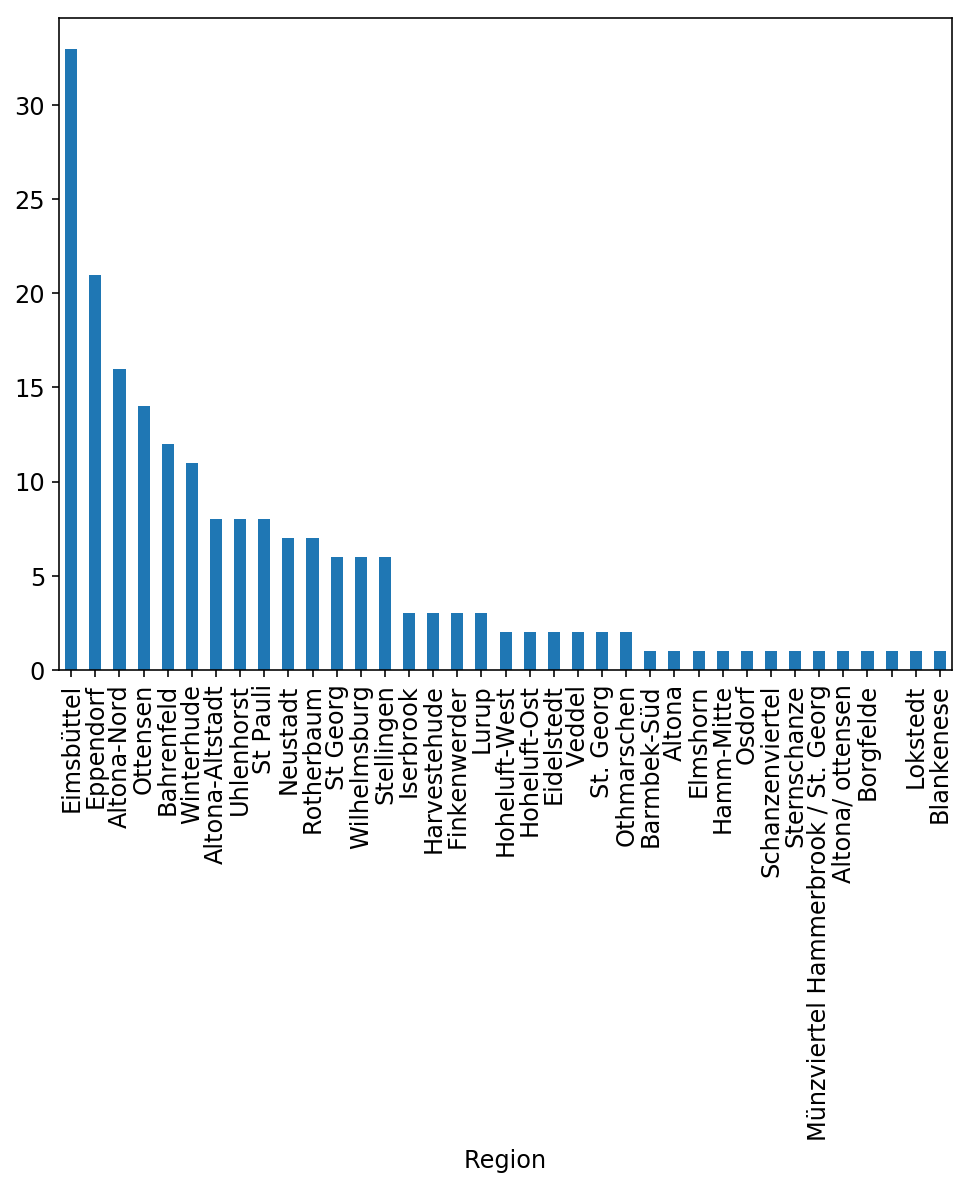

In [104]:
df.region.value_counts().plot(kind='bar');
plt.xlabel("Region");

In [105]:
df.query('15< room_area < 17').base_rent.describe()

count     31.000000
mean     417.774194
std       90.612254
min      270.000000
25%      349.500000
50%      410.000000
75%      499.500000
max      560.000000
Name: base_rent, dtype: float64

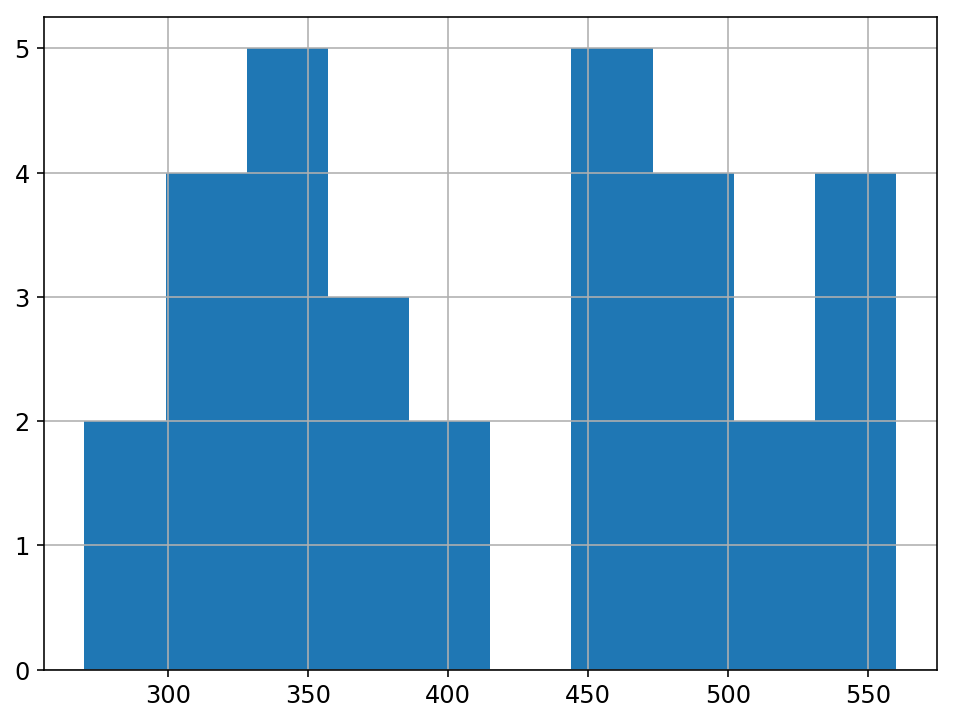

In [106]:
df.query('15< room_area < 17').base_rent.hist()

In [107]:
import gmplot

In [108]:
def pick_color(rent):
    min_col = 

SyntaxError: invalid syntax (<ipython-input-108-a5567e9f0bf8>, line 2)

In [ ]:
gmap = gmplot.GoogleMapPlotter(df.latitude.median(), df.longitude.median(), 12)
# gmap.scatter(df.latitude.values, df.longitude.values, color='red', marker=True)
# gmap.heatmap(df.latitude.values, df.longitude.values, radius=20)
for lat, long, rent in zip(df.latitude.values, df.longitude.values, df.base_rent.values):
    this_col = pick_color(rent)
    gmap.scatter(lat, long, color=this_col, marker=True)